In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from datetime import datetime
import sys
import argparse
from pathlib import Path

In [3]:
from june.geography import Geography
from june.demography.demography import (
    load_age_and_sex_generators_for_bins,
    Demography,
    Population,
    load_comorbidity_data,
    generate_comorbidity,
)
from june.paths import data_path, configs_path
from june.epidemiology.epidemiology import Epidemiology
from june.epidemiology.infection import ImmunitySetter
from june.epidemiology.infection import Infection, HealthIndexGenerator, InfectionSelector, InfectionSelectors
from june.epidemiology.infection_seed import InfectionSeed, InfectionSeeds
from june.interaction import Interaction
from june.groups import Hospital, Hospitals, Cemeteries
from june.distributors import HospitalDistributor
from june.hdf5_savers import generate_world_from_hdf5
from june.policy import Policy, Policies
from june.records import Record
from june.simulator import Simulator
from june.records import Record, RecordReader

from camps.activity import CampActivityManager
from camps.paths import camp_data_path, camp_configs_path
from camps.world import World
from camps.groups.leisure import generate_leisure_for_world, generate_leisure_for_config
from camps.camp_creation import (
    generate_empty_world,
    populate_world,
    distribute_people_to_households,
)  # this is loaded from the ../camp_scripts folder


No --data argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/data
No --configs argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/campmodelling-private/lib/python3.8/site-packages/june/configs


2022-04-18 16:05:04,270 - camps.paths - WARNING - No --camp_data argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/camp_data
2022-04-18 16:05:04,271 - camps.paths - WARNING - No --configs_camps argument given - defaulting to:
/Users/josephbullock/Documents/campmodelling/UNGP-settlement-modelling-private/configs_camps


In [4]:
from camps.groups import PumpLatrines, PumpLatrineDistributor
from camps.groups import DistributionCenters, DistributionCenterDistributor
from camps.groups import Communals, CommunalDistributor
from camps.groups import FemaleCommunals, FemaleCommunalDistributor
from camps.groups import Religiouss, ReligiousDistributor
from camps.groups import Shelter, Shelters, ShelterDistributor
from camps.groups import IsolationUnit, IsolationUnits
from camps.groups import LearningCenters
from camps.distributors import LearningCenterDistributor
from camps.groups import PlayGroups, PlayGroupDistributor
from camps.groups import EVouchers, EVoucherDistributor
from camps.groups import NFDistributionCenters, NFDistributionCenterDistributor
from camps.groups import SheltersVisitsDistributor

## Initialize the world

When we create the camp to be simulated, we call this the 'world'. The world is initialised after specifying which geographical regions you want to simulate. We can do this by using the `filter_key` argument in the `generate_empty_world` function. Cox's Bazar Expansion Site is made up of camps (which we call regions), UNHCR blocks (which we call super areas) and Mahjee blocks (which we call areas). These are the 3 heirarchical levels on which our model works. You can pass lists of the regions/super_areas/areas to the function here. Alternatively, by leaving the function empty you can generate the entire Cox's Bazar Expansion Site consisting of 112 super areas.

In [5]:
# create empty world's geography
world = generate_empty_world(filter_key = {"region" : ["CXB-219"]})

2022-04-18 16:05:05,318 - june.geography.geography - INFO - There are 65 areas and 4 super_areas and 1 regions in the world.


In [6]:
# populate empty world
populate_world(world)

In [7]:
# distribute people to households
distribute_people_to_households(world)

In [8]:
# distirbute hospitals
hospitals = Hospitals.from_file(
    filename=camp_data_path / "input/hospitals/hospitals.csv"
)
for hospital in hospitals:
    hospital.area = world.areas.get_closest_area(hospital.coordinates)
world.hospitals = hospitals
hospital_distributor = HospitalDistributor(
    hospitals, medic_min_age=20, patients_per_medic=10
)
hospital_distributor.assign_closest_hospitals_to_super_areas(
    world.super_areas
)
hospital_distributor.distribute_medics_from_world(world.people)

2022-04-18 16:05:06,086 - hospitals - INFO - There are 8 hospitals in the world.


In [9]:
world.pump_latrines = PumpLatrines.for_areas(world.areas)
world.play_groups = PlayGroups.for_areas(world.areas)
world.distribution_centers = DistributionCenters.for_areas(world.areas)
world.communals = Communals.for_areas(world.areas)
world.female_communals = FemaleCommunals.for_areas(world.areas)
world.religiouss = Religiouss.for_areas(world.areas)
world.e_vouchers = EVouchers.for_areas(world.areas)
world.n_f_distribution_centers = NFDistributionCenters.for_areas(world.areas)

2022-04-18 16:05:06,115 - social_venue - INFO - Domain 0 has 225 pump_latrines(s)
2022-04-18 16:05:06,133 - social_venue - INFO - Domain 0 has 504 play_groups(s)
2022-04-18 16:05:06,140 - social_venue - INFO - Domain 0 has 7 distribution_centers(s)
2022-04-18 16:05:06,172 - social_venue - INFO - Domain 0 has 125 communals(s)
2022-04-18 16:05:06,189 - social_venue - INFO - Domain 0 has 67 female_communals(s)
2022-04-18 16:05:06,567 - social_venue - INFO - Domain 0 has 2064 religiouss(s)
2022-04-18 16:05:06,574 - social_venue - INFO - Domain 0 has 7 e_vouchers(s)
2022-04-18 16:05:06,585 - social_venue - INFO - Domain 0 has 36 n_f_distribution_centers(s)


In [10]:
world.cemeteries = Cemeteries()

## Geography exploration

The geography is initialised first and can be explored.

### UNHCR camp blocks inside the World

In [11]:
super_areas = []
for super_area in world.super_areas:
    super_areas.append(super_area.name)

In [12]:
super_areas[:5]

['CXB-219-A', 'CXB-219-B', 'CXB-219-C', 'CXB-219-D']

### Mahjee blocks inside World

In [13]:
areas = []
for area in world.areas:
    areas.append(area.name)

In [14]:
areas[:5]

['CXB-219-001', 'CXB-219-002', 'CXB-219-003', 'CXB-219-004', 'CXB-219-005']

## Demography exploration

Once we have populated the 'digital twin' we can explore some of the attributes of the people we have created in the simulation.

### UNHCR block residents

In [15]:
sample_ages = []
sample_sexes = []
for person in world.super_areas.members[0].people:
    sample_ages.append(person.age)
    sample_sexes.append(person.sex)

In [16]:
sample_sexes[:5], sample_ages[:5]

(['f', 'm', 'f', 'f', 'f'], [46, 38, 36, 31, 17])

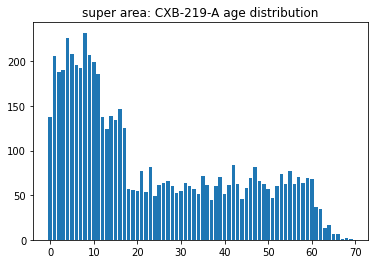

In [17]:
ages, counts = np.unique(sample_ages, return_counts=True)
plt.bar(ages, counts)
plt.title('super area: {} age distribution'.format(world.super_areas.members[0].name))
plt.show()

In [18]:
print ('The % children between ages 0-16 is {}%'.format(round(np.sum(counts[:16])/(np.sum(counts[:16])+np.sum(counts[16:]))*100)))

The % children between ages 0-16 is 49%


## Households

In this model, we will use the term 'family' and 'household' interchangeably. After populating the 'digital twin', we need to cluster people into families. To do this, we take account of age structure so that children live with adults, that there are some intergenerational households and such that we might also have some households of only adults.

### Household size distribution

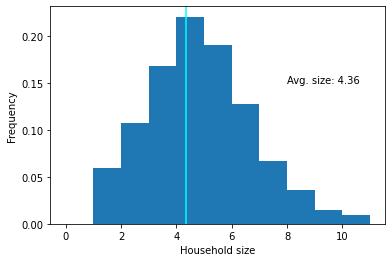

In [19]:
household_sizes = [household.size for household in world.households]
plt.hist(household_sizes, density=True, bins=np.arange(0,12))
plt.xlabel("Household size")
plt.ylabel("Frequency")
plt.axvline(np.mean(household_sizes), color="cyan")
plt.text(8, 0.150, f"Avg. size: {(np.mean(household_sizes)):.2f}")
plt.show()

# Shelters

Shelters house people in the camp. Since we know that families (houseohlds) often share shelters with other families, we can set the `sharing_shelter_ratio` to cluster families into shared shelters.

In [20]:
world.shelters = Shelters.for_areas(world.areas)
shelter_distributor = ShelterDistributor(sharing_shelter_ratio = 0.75) # proportion of families that share a shelter
for area in world.areas:
    shelter_distributor.distribute_people_in_shelters(area.shelters, area.households)

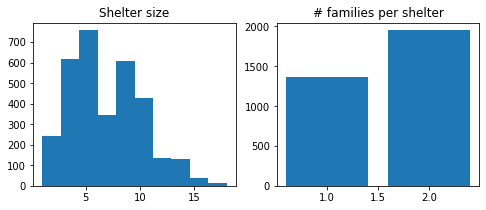

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
shelter_sizes = [shelter.size for shelter in world.shelters]
shelter_families = [shelter.n_families for shelter in world.shelters]
ax[0].hist(shelter_sizes)
ax[0].set_title("Shelter size")
shelter_families = {1 : len([shelter for shelter in world.shelters if shelter.n_families == 1]),
                    2 : len([shelter for shelter in world.shelters if shelter.n_families == 2])}
ax[1].bar(shelter_families.keys(), shelter_families.values())
ax[1].set_title("# families per shelter")
plt.show()

## Activity exploration

Once different activity locations are seeded in the 'digital twin' we can explore how many there are in different areas of the twin, and their coordinates to check they've all been added correctly.

### Pumps and latrines 

In [22]:
pumps_and_latrines = []
for pump_latrine in world.areas.members[0].pump_latrines:
    pumps_and_latrines.append(pump_latrine)

In [23]:
print ('There are {} pumps and latrines in area {}'.format(len(pumps_and_latrines), world.areas.members[0].name))

There are 4 pumps and latrines in area CXB-219-001


### Distribution centers

In [24]:
distribution_centers = []
for center in world.distribution_centers:
    distribution_centers.append(center)

In [25]:
distribution_centers[0].coordinates

array([21.21176333, 92.13597667])

### Non-food Distribution centers

In [26]:
non_food_distribution_centers = []
for center in world.n_f_distribution_centers:
    non_food_distribution_centers.append(center)

In [27]:
non_food_distribution_centers[0].coordinates

array([21.1962 , 92.14936])

### E-Voucher outlets

In [28]:
e_voucher_outlets = []
for center in world.e_vouchers:
    e_voucher_outlets.append(center)

In [29]:
e_voucher_outlets[0].coordinates

array([21.21176333, 92.13597667])

### Communal spaces

In [30]:
communal_spaces = []
for space in world.communals:
    communal_spaces.append(space)

In [31]:
communal_spaces[0].coordinates

array([21.19621, 92.14924])

### Female friendly communal spaces

In [32]:
female_communal_spaces = []
for space in world.female_communals:
    female_communal_spaces.append(space)

In [33]:
female_communal_spaces[0].coordinates

array([21.19588, 92.152  ])

### Religious sites

In [34]:
religious = []
for rel in world.religiouss:
    religious.append(rel)

In [35]:
religious[0].coordinates

array([21.20069, 92.15216])

# Adding the infection

The selector handles how infections are handled in the code. You can set different 'symptom trajectories' (e.g. exposed->mild->severe->hospitalised->intensive care) from different files. Here, we use the default.

In [36]:
selector = InfectionSelector.from_file()

In [37]:
selectors = InfectionSelectors([selector])

# Adding the interaction

The interaction class handles how many contacts people have in different locations and with who. If contact matrices are available, these can be coded in a `.yaml` file and fed into the class here.

In [38]:
interaction = Interaction.from_file(
    config_filename=camp_configs_path / "defaults/interaction/" / "ContactInteraction_med_low_low_low.yaml",
)

# Set policies

Policies control how 'operational interventions' are set in the camp. Here we set some social distancing policies, policies relating to medical care, such as people with severe symptoms being hospitalised, and individual and activity policies which can dynamically change how often and where people go, e.g. here, we close all female communal spaces and non-food distirbution centers which the camp did back in March

In [39]:
policies = Policies.from_file(
        camp_configs_path / "defaults/policy/home_care_policy.yaml",
        base_policy_modules=("june.policy", "camps.policy"),
    )

In [40]:
policies.policies

# Set comorbidities

Set initial comorbidities to people in this world. The input "comorbidities.csv" files are age-based probability matrix.

In [41]:
comorbidity_data = load_comorbidity_data(
    camp_data_path / "input/demography/myanmar_male_comorbidities.csv",
    camp_data_path / "input/demography/myanmar_female_comorbidities.csv",
)
for person in world.people:
    person.comorbidity = generate_comorbidity(person, comorbidity_data)

# Seed the disease

Set intial seeding conditions. This can be done at the camp level specifically, or generally by seeding them randomly. Here the `n_cases` is the number of randomly seeded people over the entire population.

In [42]:
infection_seed = InfectionSeed.from_uniform_cases(
    world=world, infection_selector=selector, cases_per_capita=0.01, date="2020-05-24"
)

In [43]:
infection_seeds = InfectionSeeds([infection_seed])

In [44]:
immunity_setter = ImmunitySetter.from_file_with_comorbidities(
    comorbidity_multipliers_path=camp_configs_path / "defaults/comorbidities.yaml",
    male_comorbidity_reference_prevalence_path= camp_data_path / "input/demography/uk_male_comorbidities.csv",
    female_comorbidity_reference_prevalence_path = camp_data_path / "input/demography/uk_female_comorbidities.csv",
    
)

In [45]:
epidemiology = Epidemiology(
    infection_selectors=selectors,
    infection_seeds=infection_seeds,
    immunity_setter=immunity_setter,
)

## Select config file

Before running the simualtion we must select the config file which defines how the world is set up and the simualtor will work. Specifically, the condif file specifies which activities will be included, how long we'll run the simualtion for, what the initial starting day will be and what the structure of weekdays and weekends will look like (if different)

In [46]:
CONFIG_PATH = "../configs_camps/config_demo.yaml"

# Initialise activities

The final step to intialising the simulator class which brings all of this together is to inialise all the activity distirbutors (the term 'leisure' is a legacy of the original version of this code used for modelling COVID-19 in the UK). This will mean that people know where they can go at and given time.

In [47]:
leisure = generate_leisure_for_config(world=world, config_filename=CONFIG_PATH)
leisure.leisure_distributors = {}
leisure.leisure_distributors["pump_latrine"] = PumpLatrineDistributor.from_config(
    world.pump_latrines
)
leisure.leisure_distributors["play_group"] = PlayGroupDistributor.from_config(
    world.play_groups
)
leisure.leisure_distributors[
    "distribution_center"
] = DistributionCenterDistributor.from_config(world.distribution_centers)
leisure.leisure_distributors["communal"] = CommunalDistributor.from_config(
    world.communals
)
leisure.leisure_distributors[
    "female_communals"
] = FemaleCommunalDistributor.from_config(world.female_communals)
leisure.leisure_distributors["religious"] = ReligiousDistributor.from_config(
    world.religiouss
)
leisure.leisure_distributors["e_voucher"] = EVoucherDistributor.from_config(
    world.e_vouchers
)
leisure.leisure_distributors[
    "n_f_distribution_center"
] = NFDistributionCenterDistributor.from_config(world.n_f_distribution_centers)
leisure.leisure_distributors[
    "shelters_visits"
] = SheltersVisitsDistributor.from_config()
leisure.leisure_distributors["shelters_visits"].link_shelters_to_shelters(
    world.super_areas
)
# associate social activities to shelters
leisure.distribute_social_venues_to_areas(world.areas, world.super_areas)

2022-04-18 16:05:09,090 - leisure - INFO - Linking households and care homes for visits
2022-04-18 16:05:09,090 - leisure - INFO - Done
2022-04-18 16:05:09,091 - leisure - INFO - Distributing social venues to areas
2022-04-18 16:05:09,091 - leisure - INFO - Distributed in 0 of 65 areas.
2022-04-18 16:05:09,157 - leisure - INFO - Distributed in 65 of 65 areas.


# Initialise simulator and run

The recorder is defined which will log all interactions and infections in the simualation for later analysis. The `record_path` can be changed to any path where you want the recorded data to be stored.

In [48]:
record = Record(
    record_path='results', 
    record_static_data=True
)


The simulator is defined with all the different necessary components we have built up so far

In [49]:
Simulator.ActivityManager = CampActivityManager
simulator = Simulator.from_file(
    world=world,
    interaction=interaction,
    leisure=leisure,
    policies=policies,
    config_filename=CONFIG_PATH,
    epidemiology=epidemiology,
    record=record,
)

Finally we can run a small simualation

In [50]:
%%time
simulator.run()

2022-04-18 16:05:09,402 - simulator - INFO - Starting simulation for 120 days at day 2020-05-24 00:00:00,to run for 120 days
2022-04-18 16:05:09,759 - rank - INFO - Next timestep
2022-04-18 16:05:09,760 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:09,885 - rank - INFO - Rank 0 -- move_people -- 0.12456350999999977
2022-04-18 16:05:09,885 - rank - INFO - Rank 0 -- move_people_waiting -- 3.869000000378264e-06
2022-04-18 16:05:09,886 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.0750000011560132e-06,2.1457672119140625e-06 - 2020-05-24 00:00:00
2022-04-18 16:05:09,890 - simulator - INFO - Info for rank 0, Date = 2020-05-24 00:00:00, number of deaths =  0, number of infected = 239
2022-04-18 16:05:09,945 - rank - INFO - Rank 0 -- interaction -- 0.05922670100000005
2022-04-18 16:05:09,947 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0008125259999989254,0.0008120536804199219 - 2020-05-24 00:00:00
2022-04-18 16:05:1

2022-04-18 16:05:12,834 - simulator - INFO - Info for rank 0, Date = 2020-05-25 02:00:00, number of deaths =  0, number of infected = 284
2022-04-18 16:05:12,927 - rank - INFO - Rank 0 -- interaction -- 0.09674208899999925
2022-04-18 16:05:12,932 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00034160000000049706,0.0003409385681152344 - 2020-05-25 02:00:00
2022-04-18 16:05:12,963 - rank - INFO - Rank 0 -- interaction_waiting -- 9.100999999844817e-06
2022-04-18 16:05:12,973 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010298914999999909,0.010300159454345703 - 2020-05-25 02:00:00

2022-04-18 16:05:12,974 - rank - INFO - Next timestep
2022-04-18 16:05:12,975 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:13,473 - rank - INFO - Rank 0 -- move_people -- 0.49693091600000017
2022-04-18 16:05:13,474 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00010943999999923903
2022-04-18 16:05:13,474 - activity_manager - INFO - CMS: Pe

2022-04-18 16:05:16,300 - rank - INFO - Next timestep
2022-04-18 16:05:16,300 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:16,626 - rank - INFO - Rank 0 -- move_people -- 0.3251923529999985
2022-04-18 16:05:16,627 - rank - INFO - Rank 0 -- move_people_waiting -- 5.525000000083935e-05
2022-04-18 16:05:16,627 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.440999999464566e-06,3.0994415283203125e-06 - 2020-05-26 06:00:00
2022-04-18 16:05:16,632 - simulator - INFO - Info for rank 0, Date = 2020-05-26 06:00:00, number of deaths =  0, number of infected = 390
2022-04-18 16:05:16,720 - rank - INFO - Rank 0 -- interaction -- 0.09152594000000036
2022-04-18 16:05:16,724 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005549760000000958,0.0005540847778320312 - 2020-05-26 06:00:00
2022-04-18 16:05:16,748 - rank - INFO - Rank 0 -- interaction_waiting -- 8.32100000103253e-06
2022-04-18 16:05:16,757 - simulator - INFO - CMS: T

2022-04-18 16:05:19,439 - rank - INFO - Rank 0 -- interaction -- 0.09441434600000065
2022-04-18 16:05:19,442 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003048250000006192,0.00030422210693359375 - 2020-05-27 08:00:00
2022-04-18 16:05:19,466 - rank - INFO - Rank 0 -- interaction_waiting -- 7.947000000285698e-06
2022-04-18 16:05:19,476 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009900131000001977,0.009901285171508789 - 2020-05-27 08:00:00

2022-04-18 16:05:19,477 - rank - INFO - Next timestep
2022-04-18 16:05:19,478 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:19,606 - rank - INFO - Rank 0 -- move_people -- 0.12767599300000043
2022-04-18 16:05:19,607 - rank - INFO - Rank 0 -- move_people_waiting -- 4.8100000000772525e-06
2022-04-18 16:05:19,607 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.412000000617809e-06,2.1457672119140625e-06 - 2020-05-27 10:00:00
2022-04-18 16:05:19,611 - simulator - INFO - I

2022-04-18 16:05:22,203 - rank - INFO - Rank 0 -- move_people -- 0.13354371199999804
2022-04-18 16:05:22,204 - rank - INFO - Rank 0 -- move_people_waiting -- 4.174000000745082e-06
2022-04-18 16:05:22,204 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 9.951000002672572e-06,4.291534423828125e-06 - 2020-05-29 00:00:00
2022-04-18 16:05:22,209 - simulator - INFO - Info for rank 0, Date = 2020-05-29 00:00:00, number of deaths =  0, number of infected = 788
2022-04-18 16:05:22,265 - rank - INFO - Rank 0 -- interaction -- 0.05975049399999932
2022-04-18 16:05:22,271 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021564100000048825,0.00021386146545410156 - 2020-05-29 00:00:00
2022-04-18 16:05:22,296 - rank - INFO - Rank 0 -- interaction_waiting -- 8.16500000055953e-06
2022-04-18 16:05:22,306 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009230029000001139,0.009231090545654297 - 2020-05-29 00:00:00

2022-04-18 16:05:22,307 - rank - INFO - Next timestep
2022-0

2022-04-18 16:05:25,107 - rank - INFO - Rank 0 -- interaction_waiting -- 8.366999999509517e-06
2022-04-18 16:05:25,117 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009524513000002344,0.00952601432800293 - 2020-05-30 03:00:00

2022-04-18 16:05:25,118 - rank - INFO - Next timestep
2022-04-18 16:05:25,119 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:25,438 - rank - INFO - Rank 0 -- move_people -- 0.3183374619999988
2022-04-18 16:05:25,438 - rank - INFO - Rank 0 -- move_people_waiting -- 4.09600000139676e-06
2022-04-18 16:05:25,439 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0879999997068808e-06,2.6226043701171875e-06 - 2020-05-30 05:00:00
2022-04-18 16:05:25,444 - simulator - INFO - Info for rank 0, Date = 2020-05-30 05:00:00, number of deaths =  0, number of infected = 981
2022-04-18 16:05:25,549 - rank - INFO - Rank 0 -- interaction -- 0.10985247900000061
2022-04-18 16:05:25,556 - epidemiology - INFO - CMS: Infection C

2022-04-18 16:05:28,267 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.607999999071353e-06,3.0994415283203125e-06 - 2020-05-31 07:00:00
2022-04-18 16:05:28,271 - simulator - INFO - Info for rank 0, Date = 2020-05-31 07:00:00, number of deaths =  0, number of infected = 1177
2022-04-18 16:05:28,377 - rank - INFO - Rank 0 -- interaction -- 0.10889759699999857
2022-04-18 16:05:28,384 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005548180000012337,0.0005538463592529297 - 2020-05-31 07:00:00
2022-04-18 16:05:28,412 - rank - INFO - Rank 0 -- interaction_waiting -- 8.460000000098944e-06
2022-04-18 16:05:28,423 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010439042000001564,0.010442972183227539 - 2020-05-31 07:00:00

2022-04-18 16:05:28,424 - rank - INFO - Next timestep
2022-04-18 16:05:28,425 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:28,757 - rank - INFO - Rank 0 -- move_people -- 0.3313087569999986
2022-

2022-04-18 16:05:31,271 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009860605000000078,0.009861946105957031 - 2020-06-01 08:00:00

2022-04-18 16:05:31,273 - rank - INFO - Next timestep
2022-04-18 16:05:31,274 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:31,407 - rank - INFO - Rank 0 -- move_people -- 0.13299056399999998
2022-04-18 16:05:31,408 - rank - INFO - Rank 0 -- move_people_waiting -- 5.545000000495293e-06
2022-04-18 16:05:31,408 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.624000000395199e-06,1.9073486328125e-06 - 2020-06-01 10:00:00
2022-04-18 16:05:31,412 - simulator - INFO - Info for rank 0, Date = 2020-06-01 10:00:00, number of deaths =  0, number of infected = 1368
2022-04-18 16:05:31,481 - rank - INFO - Rank 0 -- interaction -- 0.07228770900000114
2022-04-18 16:05:31,508 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00038365600000034306,0.0003829002380371094 - 2020-06-01 10:00:00
2022-0

2022-04-18 16:05:34,098 - simulator - INFO - Info for rank 0, Date = 2020-06-03 00:00:00, number of deaths =  0, number of infected = 1634
2022-04-18 16:05:34,157 - rank - INFO - Rank 0 -- interaction -- 0.06237575600000156
2022-04-18 16:05:34,164 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00016704699999792183,0.0001671314239501953 - 2020-06-03 00:00:00
2022-04-18 16:05:34,193 - rank - INFO - Rank 0 -- interaction_waiting -- 8.441999995056904e-06
2022-04-18 16:05:34,203 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009547814999997684,0.009550094604492188 - 2020-06-03 00:00:00

2022-04-18 16:05:34,204 - rank - INFO - Next timestep
2022-04-18 16:05:34,205 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:34,523 - rank - INFO - Rank 0 -- move_people -- 0.3171839339999991
2022-04-18 16:05:34,523 - rank - INFO - Rank 0 -- move_people_waiting -- 1.2099999999293232e-05
2022-04-18 16:05:34,524 - activity_manager - INFO - CMS: Pe

2022-04-18 16:05:37,296 - rank - INFO - Next timestep
2022-04-18 16:05:37,296 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:37,613 - rank - INFO - Rank 0 -- move_people -- 0.31634544700000333
2022-04-18 16:05:37,614 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00018137899999715046
2022-04-18 16:05:37,615 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.2430000043982545e-06,1.9073486328125e-06 - 2020-06-04 04:00:00
2022-04-18 16:05:37,619 - simulator - INFO - Info for rank 0, Date = 2020-06-04 04:00:00, number of deaths =  0, number of infected = 1834
2022-04-18 16:05:37,726 - rank - INFO - Rank 0 -- interaction -- 0.11037346300000195
2022-04-18 16:05:37,734 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00036501599999638756,0.0003650188446044922 - 2020-06-04 04:00:00
2022-04-18 16:05:37,768 - rank - INFO - Rank 0 -- interaction_waiting -- 8.06399999930818e-06
2022-04-18 16:05:37,777 - simulator - INFO - CMS:

2022-04-18 16:05:40,687 - rank - INFO - Rank 0 -- interaction -- 0.11066559900000073
2022-04-18 16:05:40,697 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005844769999967525,0.0005838871002197266 - 2020-06-05 06:00:00
2022-04-18 16:05:40,726 - rank - INFO - Rank 0 -- interaction_waiting -- 8.387999997694351e-06
2022-04-18 16:05:40,736 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009608759000002465,0.00960993766784668 - 2020-06-05 06:00:00

2022-04-18 16:05:40,738 - rank - INFO - Next timestep
2022-04-18 16:05:40,738 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:41,056 - rank - INFO - Rank 0 -- move_people -- 0.3167503310000015
2022-04-18 16:05:41,056 - rank - INFO - Rank 0 -- move_people_waiting -- 6.269000003555902e-06
2022-04-18 16:05:41,057 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5730000032808675e-06,2.1457672119140625e-06 - 2020-06-05 08:00:00
2022-04-18 16:05:41,061 - simulator - INFO - Info

2022-04-18 16:05:43,849 - rank - INFO - Rank 0 -- move_people -- 0.12902971300000132
2022-04-18 16:05:43,849 - rank - INFO - Rank 0 -- move_people_waiting -- 3.795000004913618e-06
2022-04-18 16:05:43,850 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4439999961600734e-06,1.9073486328125e-06 - 2020-06-06 11:00:00
2022-04-18 16:05:43,854 - simulator - INFO - Info for rank 0, Date = 2020-06-06 11:00:00, number of deaths =  0, number of infected = 2236
2022-04-18 16:05:43,930 - rank - INFO - Rank 0 -- interaction -- 0.07969468699999993
2022-04-18 16:05:43,955 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006711289999969949,0.0006701946258544922 - 2020-06-06 11:00:00
2022-04-18 16:05:43,986 - rank - INFO - Rank 0 -- interaction_waiting -- 8.723999997073406e-06
2022-04-18 16:05:43,996 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010572537000001603,0.010574102401733398 - 2020-06-06 11:00:00

2022-04-18 16:05:43,998 - rank - INFO - Next timestep
2022-04

2022-04-18 16:05:46,905 - rank - INFO - Rank 0 -- interaction_waiting -- 8.784999998567855e-06
2022-04-18 16:05:46,916 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010761965000000373,0.010762929916381836 - 2020-06-08 00:00:00

2022-04-18 16:05:46,918 - rank - INFO - Next timestep
2022-04-18 16:05:46,919 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:47,249 - rank - INFO - Rank 0 -- move_people -- 0.3293768799999981
2022-04-18 16:05:47,249 - rank - INFO - Rank 0 -- move_people_waiting -- 6.001999999227792e-06
2022-04-18 16:05:47,250 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.53599999666676e-06,3.0994415283203125e-06 - 2020-06-08 02:00:00
2022-04-18 16:05:47,253 - simulator - INFO - Info for rank 0, Date = 2020-06-08 02:00:00, number of deaths =  1, number of infected = 2508
2022-04-18 16:05:47,370 - rank - INFO - Rank 0 -- interaction -- 0.11990743699999484
2022-04-18 16:05:47,381 - epidemiology - INFO - CMS: Infection 

2022-04-18 16:05:50,764 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5280000031102645e-06,2.1457672119140625e-06 - 2020-06-09 04:00:00
2022-04-18 16:05:50,769 - simulator - INFO - Info for rank 0, Date = 2020-06-09 04:00:00, number of deaths =  1, number of infected = 2716
2022-04-18 16:05:50,888 - rank - INFO - Rank 0 -- interaction -- 0.1231727489999983
2022-04-18 16:05:50,897 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005571129999992763,0.0005559921264648438 - 2020-06-09 04:00:00
2022-04-18 16:05:50,931 - rank - INFO - Rank 0 -- interaction_waiting -- 8.184999998661624e-06
2022-04-18 16:05:50,941 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009559578000001068,0.009562015533447266 - 2020-06-09 04:00:00

2022-04-18 16:05:50,942 - rank - INFO - Next timestep
2022-04-18 16:05:50,943 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:51,258 - rank - INFO - Rank 0 -- move_people -- 0.3143836879999995
2022-

2022-04-18 16:05:54,269 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01002958399999443,0.010030746459960938 - 2020-06-10 06:00:00

2022-04-18 16:05:54,270 - rank - INFO - Next timestep
2022-04-18 16:05:54,271 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:54,608 - rank - INFO - Rank 0 -- move_people -- 0.33663473500000407
2022-04-18 16:05:54,609 - rank - INFO - Rank 0 -- move_people_waiting -- 1.376600000213557e-05
2022-04-18 16:05:54,610 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8409999970335775e-06,1.6689300537109375e-06 - 2020-06-10 08:00:00
2022-04-18 16:05:54,615 - simulator - INFO - Info for rank 0, Date = 2020-06-10 08:00:00, number of deaths =  1, number of infected = 2921
2022-04-18 16:05:54,736 - rank - INFO - Rank 0 -- interaction -- 0.1262047339999981
2022-04-18 16:05:54,744 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00046592800000411216,0.0004649162292480469 - 2020-06-10 08:00:00
2022

2022-04-18 16:05:57,839 - simulator - INFO - Info for rank 0, Date = 2020-06-11 10:00:00, number of deaths =  1, number of infected = 3084
2022-04-18 16:05:57,918 - rank - INFO - Rank 0 -- interaction -- 0.08277469200000098
2022-04-18 16:05:57,953 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001923700000006079,0.00019097328186035156 - 2020-06-11 10:00:00
2022-04-18 16:05:57,992 - rank - INFO - Rank 0 -- interaction_waiting -- 8.156999996344894e-06
2022-04-18 16:05:58,002 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.00995301300000051,0.009955883026123047 - 2020-06-11 10:00:00

2022-04-18 16:05:58,004 - rank - INFO - Next timestep
2022-04-18 16:05:58,005 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:05:58,142 - rank - INFO - Rank 0 -- move_people -- 0.13644145399999985
2022-04-18 16:05:58,143 - rank - INFO - Rank 0 -- move_people_waiting -- 3.431999999747859e-06
2022-04-18 16:05:58,143 - activity_manager - INFO - CMS: Peo

2022-04-18 16:06:01,019 - rank - INFO - Next timestep
2022-04-18 16:06:01,020 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:06:01,363 - rank - INFO - Rank 0 -- move_people -- 0.3432861840000001
2022-04-18 16:06:01,364 - rank - INFO - Rank 0 -- move_people_waiting -- 3.3990000005701404e-06
2022-04-18 16:06:01,364 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.849000004800928e-06,1.6689300537109375e-06 - 2020-06-13 03:00:00
2022-04-18 16:06:01,369 - simulator - INFO - Info for rank 0, Date = 2020-06-13 03:00:00, number of deaths =  2, number of infected = 3320
2022-04-18 16:06:01,497 - rank - INFO - Rank 0 -- interaction -- 0.1324702490000007
2022-04-18 16:06:01,504 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005211739999992915,0.0005199909210205078 - 2020-06-13 03:00:00
2022-04-18 16:06:01,546 - rank - INFO - Rank 0 -- interaction_waiting -- 9.47999999567628e-06
2022-04-18 16:06:01,557 - simulator - INFO - CMS: 

2022-04-18 16:06:04,866 - rank - INFO - Rank 0 -- interaction -- 0.1306313409999973
2022-04-18 16:06:04,871 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00023834600000327555,0.00023818016052246094 - 2020-06-14 05:00:00
2022-04-18 16:06:04,909 - rank - INFO - Rank 0 -- interaction_waiting -- 9.257000002094173e-06
2022-04-18 16:06:04,921 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012062616999998,0.012064933776855469 - 2020-06-14 05:00:00

2022-04-18 16:06:04,922 - rank - INFO - Next timestep
2022-04-18 16:06:04,923 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:06:05,269 - rank - INFO - Rank 0 -- move_people -- 0.3458481619999958
2022-04-18 16:06:05,270 - rank - INFO - Rank 0 -- move_people_waiting -- 3.4749999997529812e-06
2022-04-18 16:06:05,270 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8890000010051153e-06,3.0994415283203125e-06 - 2020-06-14 07:00:00
2022-04-18 16:06:05,275 - simulator - INFO - Info

2022-04-18 16:06:08,634 - rank - INFO - Rank 0 -- move_people -- 0.33179653400000575
2022-04-18 16:06:08,635 - rank - INFO - Rank 0 -- move_people_waiting -- 2.736700000127712e-05
2022-04-18 16:06:08,636 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.926999997043822e-06,1.9073486328125e-06 - 2020-06-15 08:00:00
2022-04-18 16:06:08,640 - simulator - INFO - Info for rank 0, Date = 2020-06-15 08:00:00, number of deaths =  2, number of infected = 3598
2022-04-18 16:06:08,767 - rank - INFO - Rank 0 -- interaction -- 0.13042691200000434
2022-04-18 16:06:08,774 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002346349999982067,0.0002338886260986328 - 2020-06-15 08:00:00
2022-04-18 16:06:08,812 - rank - INFO - Rank 0 -- interaction_waiting -- 8.164000007582217e-06
2022-04-18 16:06:08,821 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009084052999995151,0.009086132049560547 - 2020-06-15 08:00:00

2022-04-18 16:06:08,822 - rank - INFO - Next timestep
2022-04-

2022-04-18 16:06:11,965 - rank - INFO - Rank 0 -- interaction_waiting -- 8.339999993722813e-06
2022-04-18 16:06:11,974 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.00888195699999983,0.008883237838745117 - 2020-06-16 10:00:00

2022-04-18 16:06:11,976 - rank - INFO - Next timestep
2022-04-18 16:06:11,976 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:06:12,121 - rank - INFO - Rank 0 -- move_people -- 0.14388988599999664
2022-04-18 16:06:12,121 - rank - INFO - Rank 0 -- move_people_waiting -- 8.441000005632304e-06
2022-04-18 16:06:12,122 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.354999992348894e-06,1.9073486328125e-06 - 2020-06-17 00:00:00
2022-04-18 16:06:12,126 - simulator - INFO - Info for rank 0, Date = 2020-06-17 00:00:00, number of deaths =  2, number of infected = 3770
2022-04-18 16:06:12,206 - rank - INFO - Rank 0 -- interaction -- 0.08367857300000026
2022-04-18 16:06:12,214 - epidemiology - INFO - CMS: Infection CO

2022-04-18 16:06:15,495 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.9130000029908842e-06,2.1457672119140625e-06 - 2020-06-18 02:00:00
2022-04-18 16:06:15,499 - simulator - INFO - Info for rank 0, Date = 2020-06-18 02:00:00, number of deaths =  2, number of infected = 3881
2022-04-18 16:06:15,638 - rank - INFO - Rank 0 -- interaction -- 0.14203606399999558
2022-04-18 16:06:15,647 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002457800000001953,0.00024509429931640625 - 2020-06-18 02:00:00
2022-04-18 16:06:15,698 - rank - INFO - Rank 0 -- interaction_waiting -- 1.847200000781868e-05
2022-04-18 16:06:15,708 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010555564000000572,0.010558128356933594 - 2020-06-18 02:00:00

2022-04-18 16:06:15,710 - rank - INFO - Next timestep
2022-04-18 16:06:15,711 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:06:16,054 - rank - INFO - Rank 0 -- move_people -- 0.3424378059999924
202

2022-04-18 16:06:19,069 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010205472999999188,0.010206937789916992 - 2020-06-19 04:00:00

2022-04-18 16:06:19,070 - rank - INFO - Next timestep
2022-04-18 16:06:19,071 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:06:19,407 - rank - INFO - Rank 0 -- move_people -- 0.33564169899999285
2022-04-18 16:06:19,408 - rank - INFO - Rank 0 -- move_people_waiting -- 8.497400000351263e-05
2022-04-18 16:06:19,408 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.394999995658509e-06,2.1457672119140625e-06 - 2020-06-19 06:00:00
2022-04-18 16:06:19,412 - simulator - INFO - Info for rank 0, Date = 2020-06-19 06:00:00, number of deaths =  5, number of infected = 3976
2022-04-18 16:06:19,565 - rank - INFO - Rank 0 -- interaction -- 0.1567011709999946
2022-04-18 16:06:19,572 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020032099999411912,0.0001990795135498047 - 2020-06-19 06:00:00
2022

2022-04-18 16:06:22,934 - simulator - INFO - Info for rank 0, Date = 2020-06-20 09:00:00, number of deaths =  5, number of infected = 4074
2022-04-18 16:06:23,076 - rank - INFO - Rank 0 -- interaction -- 0.14542475199999672
2022-04-18 16:06:23,081 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00037178899999901205,0.00037097930908203125 - 2020-06-20 09:00:00
2022-04-18 16:06:23,123 - rank - INFO - Rank 0 -- interaction_waiting -- 4.700999994611266e-06
2022-04-18 16:06:23,132 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009290026999991596,0.009293079376220703 - 2020-06-20 09:00:00

2022-04-18 16:06:23,133 - rank - INFO - Next timestep
2022-04-18 16:06:23,134 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:06:23,265 - rank - INFO - Rank 0 -- move_people -- 0.13059256400001118
2022-04-18 16:06:23,266 - rank - INFO - Rank 0 -- move_people_waiting -- 3.7309999925128068e-06
2022-04-18 16:06:23,266 - activity_manager - INFO - CMS: 

2022-04-18 16:06:26,440 - rank - INFO - Next timestep
2022-04-18 16:06:26,441 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:06:26,594 - rank - INFO - Rank 0 -- move_people -- 0.1522568480000075
2022-04-18 16:06:26,595 - rank - INFO - Rank 0 -- move_people_waiting -- 6.565300000715979e-05
2022-04-18 16:06:26,596 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.812000005292248e-06,2.86102294921875e-06 - 2020-06-22 00:00:00
2022-04-18 16:06:26,600 - simulator - INFO - Info for rank 0, Date = 2020-06-22 00:00:00, number of deaths =  5, number of infected = 4181
2022-04-18 16:06:26,698 - rank - INFO - Rank 0 -- interaction -- 0.10198847899999919
2022-04-18 16:06:26,707 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005829450000049974,0.0005817413330078125 - 2020-06-22 00:00:00
2022-04-18 16:06:26,755 - rank - INFO - Rank 0 -- interaction_waiting -- 5.483999999000844e-06
2022-04-18 16:06:26,767 - simulator - INFO - CMS: T

2022-04-18 16:06:30,324 - rank - INFO - Rank 0 -- interaction -- 0.15071507099999337
2022-04-18 16:06:30,330 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022644700000284956,0.00022602081298828125 - 2020-06-23 02:00:00
2022-04-18 16:06:30,375 - rank - INFO - Rank 0 -- interaction_waiting -- 8.659000002353423e-06
2022-04-18 16:06:30,385 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009668597000001,0.009670019149780273 - 2020-06-23 02:00:00

2022-04-18 16:06:30,386 - rank - INFO - Next timestep
2022-04-18 16:06:30,387 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:06:30,737 - rank - INFO - Rank 0 -- move_people -- 0.34959998099999723
2022-04-18 16:06:30,738 - rank - INFO - Rank 0 -- move_people_waiting -- 5.901400000141166e-05
2022-04-18 16:06:30,738 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 4.187999991245306e-06,3.0994415283203125e-06 - 2020-06-23 04:00:00
2022-04-18 16:06:30,744 - simulator - INFO - Info

2022-04-18 16:06:34,181 - rank - INFO - Rank 0 -- move_people -- 0.33447655799999154
2022-04-18 16:06:34,182 - rank - INFO - Rank 0 -- move_people_waiting -- 8.911700000169276e-05
2022-04-18 16:06:34,182 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.55300000162606e-06,2.1457672119140625e-06 - 2020-06-24 06:00:00
2022-04-18 16:06:34,187 - simulator - INFO - Info for rank 0, Date = 2020-06-24 06:00:00, number of deaths =  5, number of infected = 4302
2022-04-18 16:06:34,319 - rank - INFO - Rank 0 -- interaction -- 0.1358531460000023
2022-04-18 16:06:34,324 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001515889999978981,0.00015115737915039062 - 2020-06-24 06:00:00
2022-04-18 16:06:34,369 - rank - INFO - Rank 0 -- interaction_waiting -- 8.479000001671011e-06
2022-04-18 16:06:34,379 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009852226999996105,0.00985407829284668 - 2020-06-24 06:00:00

2022-04-18 16:06:34,381 - rank - INFO - Next timestep
2022-04

2022-04-18 16:06:37,598 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003812459999892326,0.0003800392150878906 - 2020-06-25 08:00:00
2022-04-18 16:06:37,640 - rank - INFO - Rank 0 -- interaction_waiting -- 8.436000001665889e-06
2022-04-18 16:06:37,650 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009763168999995742,0.009763956069946289 - 2020-06-25 08:00:00

2022-04-18 16:06:37,651 - rank - INFO - Next timestep
2022-04-18 16:06:37,652 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:06:37,788 - rank - INFO - Rank 0 -- move_people -- 0.13641686500000105
2022-04-18 16:06:37,789 - rank - INFO - Rank 0 -- move_people_waiting -- 3.942999995842911e-06
2022-04-18 16:06:37,790 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5650000026189446e-06,2.1457672119140625e-06 - 2020-06-25 10:00:00
2022-04-18 16:06:37,794 - simulator - INFO - Info for rank 0, Date = 2020-06-25 10:00:00, number of deaths =  5, number of infected 

2022-04-18 16:06:40,960 - rank - INFO - Rank 0 -- move_people_waiting -- 6.290299999989202e-05
2022-04-18 16:06:40,961 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6149999996505358e-06,1.9073486328125e-06 - 2020-06-27 00:00:00
2022-04-18 16:06:40,965 - simulator - INFO - Info for rank 0, Date = 2020-06-27 00:00:00, number of deaths =  5, number of infected = 4422
2022-04-18 16:06:41,063 - rank - INFO - Rank 0 -- interaction -- 0.10150391899999534
2022-04-18 16:06:41,075 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00040376699999455923,0.0004029273986816406 - 2020-06-27 00:00:00
2022-04-18 16:06:41,120 - rank - INFO - Rank 0 -- interaction_waiting -- 8.020999999303058e-06
2022-04-18 16:06:41,129 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.008965100000011716,0.008966207504272461 - 2020-06-27 00:00:00

2022-04-18 16:06:41,130 - rank - INFO - Next timestep
2022-04-18 16:06:41,130 - simulator - INFO - ==================== timestep ================

2022-04-18 16:06:44,655 - rank - INFO - Rank 0 -- interaction_waiting -- 0.0002196259999891481
2022-04-18 16:06:44,665 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009801103000000921,0.009801864624023438 - 2020-06-28 03:00:00

2022-04-18 16:06:44,666 - rank - INFO - Next timestep
2022-04-18 16:06:44,667 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:06:45,027 - rank - INFO - Rank 0 -- move_people -- 0.35985333300000377
2022-04-18 16:06:45,028 - rank - INFO - Rank 0 -- move_people_waiting -- 3.375999995114398e-06
2022-04-18 16:06:45,028 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.008000007298506e-06,3.0994415283203125e-06 - 2020-06-28 05:00:00
2022-04-18 16:06:45,033 - simulator - INFO - Info for rank 0, Date = 2020-06-28 05:00:00, number of deaths =  5, number of infected = 4493
2022-04-18 16:06:45,230 - rank - INFO - Rank 0 -- interaction -- 0.20161442699999554
2022-04-18 16:06:45,238 - epidemiology - INFO - CMS: Infectio

2022-04-18 16:06:48,665 - simulator - INFO - Info for rank 0, Date = 2020-06-29 06:00:00, number of deaths =  5, number of infected = 4516
2022-04-18 16:06:48,823 - rank - INFO - Rank 0 -- interaction -- 0.16301604500000622
2022-04-18 16:06:48,832 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004190300000033176,0.00041794776916503906 - 2020-06-29 06:00:00
2022-04-18 16:06:48,879 - rank - INFO - Rank 0 -- interaction_waiting -- 9.28400000077545e-06
2022-04-18 16:06:48,889 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01029520299999831,0.010296106338500977 - 2020-06-29 06:00:00

2022-04-18 16:06:48,891 - rank - INFO - Next timestep
2022-04-18 16:06:48,891 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:06:49,232 - rank - INFO - Rank 0 -- move_people -- 0.34017982999999674
2022-04-18 16:06:49,233 - rank - INFO - Rank 0 -- move_people_waiting -- 4.460999988964431e-06
2022-04-18 16:06:49,233 - activity_manager - INFO - CMS: Peop

2022-04-18 16:06:52,426 - rank - INFO - Next timestep
2022-04-18 16:06:52,426 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:06:52,570 - rank - INFO - Rank 0 -- move_people -- 0.14293514599999924
2022-04-18 16:06:52,570 - rank - INFO - Rank 0 -- move_people_waiting -- 3.8089999918611284e-06
2022-04-18 16:06:52,571 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.901000001998e-06,1.9073486328125e-06 - 2020-06-30 10:00:00
2022-04-18 16:06:52,575 - simulator - INFO - Info for rank 0, Date = 2020-06-30 10:00:00, number of deaths =  6, number of infected = 4589
2022-04-18 16:06:52,690 - rank - INFO - Rank 0 -- interaction -- 0.11881287900000359
2022-04-18 16:06:52,728 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.001080246000000784,0.0010788440704345703 - 2020-06-30 10:00:00
2022-04-18 16:06:52,771 - rank - INFO - Rank 0 -- interaction_waiting -- 8.010999991370227e-06
2022-04-18 16:06:52,781 - simulator - INFO - CMS: Time

2022-04-18 16:06:55,922 - rank - INFO - Rank 0 -- interaction -- 0.09753139800000099
2022-04-18 16:06:55,928 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00019321700000318742,0.00019288063049316406 - 2020-07-02 00:00:00
2022-04-18 16:06:55,973 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1982000003740723e-05
2022-04-18 16:06:55,982 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009489207000001443,0.009485960006713867 - 2020-07-02 00:00:00

2022-04-18 16:06:55,984 - rank - INFO - Next timestep
2022-04-18 16:06:55,984 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:06:56,325 - rank - INFO - Rank 0 -- move_people -- 0.3401418819999975
2022-04-18 16:06:56,325 - rank - INFO - Rank 0 -- move_people_waiting -- 6.193999993797661e-06
2022-04-18 16:06:56,326 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.620000001092194e-06,2.86102294921875e-06 - 2020-07-02 02:00:00
2022-04-18 16:06:56,330 - simulator - INFO - Inf

2022-04-18 16:06:59,724 - rank - INFO - Rank 0 -- move_people -- 0.3273060300000026
2022-04-18 16:06:59,725 - rank - INFO - Rank 0 -- move_people_waiting -- 6.264000006694914e-06
2022-04-18 16:06:59,725 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.260000002252127e-06,2.1457672119140625e-06 - 2020-07-03 04:00:00
2022-04-18 16:06:59,729 - simulator - INFO - Info for rank 0, Date = 2020-07-03 04:00:00, number of deaths =  6, number of infected = 4719
2022-04-18 16:06:59,866 - rank - INFO - Rank 0 -- interaction -- 0.14109500600000047
2022-04-18 16:06:59,873 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003491399999973055,0.00034928321838378906 - 2020-07-03 04:00:00
2022-04-18 16:06:59,916 - rank - INFO - Rank 0 -- interaction_waiting -- 7.908000000611537e-06
2022-04-18 16:06:59,925 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009049464000000285,0.009050846099853516 - 2020-07-03 04:00:00

2022-04-18 16:06:59,926 - rank - INFO - Next timestep
2022-

2022-04-18 16:07:03,279 - rank - INFO - Rank 0 -- interaction_waiting -- 8.141999998656502e-06
2022-04-18 16:07:03,290 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010542103999995334,0.010544061660766602 - 2020-07-04 07:00:00

2022-04-18 16:07:03,291 - rank - INFO - Next timestep
2022-04-18 16:07:03,292 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:03,621 - rank - INFO - Rank 0 -- move_people -- 0.3288443240000021
2022-04-18 16:07:03,621 - rank - INFO - Rank 0 -- move_people_waiting -- 1.7757999998480045e-05
2022-04-18 16:07:03,622 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7600000009897485e-06,3.0994415283203125e-06 - 2020-07-04 09:00:00
2022-04-18 16:07:03,626 - simulator - INFO - Info for rank 0, Date = 2020-07-04 09:00:00, number of deaths =  6, number of infected = 4753
2022-04-18 16:07:03,764 - rank - INFO - Rank 0 -- interaction -- 0.140869090999999
2022-04-18 16:07:03,772 - epidemiology - INFO - CMS: Infection

2022-04-18 16:07:07,009 - simulator - INFO - Info for rank 0, Date = 2020-07-05 11:00:00, number of deaths =  6, number of infected = 4761
2022-04-18 16:07:07,125 - rank - INFO - Rank 0 -- interaction -- 0.12092253099999084
2022-04-18 16:07:07,160 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002316830000097525,0.00023126602172851562 - 2020-07-05 11:00:00
2022-04-18 16:07:07,203 - rank - INFO - Rank 0 -- interaction_waiting -- 9.718999990582233e-06
2022-04-18 16:07:07,213 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010238674999996533,0.010239839553833008 - 2020-07-05 11:00:00

2022-04-18 16:07:07,215 - rank - INFO - Next timestep
2022-04-18 16:07:07,216 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:07,356 - rank - INFO - Rank 0 -- move_people -- 0.14021844200000544
2022-04-18 16:07:07,357 - rank - INFO - Rank 0 -- move_people_waiting -- 5.1590000111900736e-06
2022-04-18 16:07:07,357 - activity_manager - INFO - CMS: P

2022-04-18 16:07:10,376 - rank - INFO - Next timestep
2022-04-18 16:07:10,376 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:10,703 - rank - INFO - Rank 0 -- move_people -- 0.3262333330000047
2022-04-18 16:07:10,704 - rank - INFO - Rank 0 -- move_people_waiting -- 2.5136000004977177e-05
2022-04-18 16:07:10,704 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.356999999619802e-06,2.1457672119140625e-06 - 2020-07-07 02:00:00
2022-04-18 16:07:10,709 - simulator - INFO - Info for rank 0, Date = 2020-07-07 02:00:00, number of deaths =  6, number of infected = 4774
2022-04-18 16:07:10,847 - rank - INFO - Rank 0 -- interaction -- 0.14170890200000485
2022-04-18 16:07:10,854 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004371349999985341,0.00043702125549316406 - 2020-07-07 02:00:00
2022-04-18 16:07:10,898 - rank - INFO - Rank 0 -- interaction_waiting -- 8.084000000962988e-06
2022-04-18 16:07:10,907 - simulator - INFO - CM

2022-04-18 16:07:14,210 - rank - INFO - Rank 0 -- interaction -- 0.14518330399999968
2022-04-18 16:07:14,215 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020099299999287723,0.00020122528076171875 - 2020-07-08 04:00:00
2022-04-18 16:07:14,258 - rank - INFO - Rank 0 -- interaction_waiting -- 8.196999999654508e-06
2022-04-18 16:07:14,268 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009658357999995815,0.009659051895141602 - 2020-07-08 04:00:00

2022-04-18 16:07:14,269 - rank - INFO - Next timestep
2022-04-18 16:07:14,270 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:14,601 - rank - INFO - Rank 0 -- move_people -- 0.3303668060000007
2022-04-18 16:07:14,601 - rank - INFO - Rank 0 -- move_people_waiting -- 5.600000008598727e-06
2022-04-18 16:07:14,602 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5209999989783682e-06,3.0994415283203125e-06 - 2020-07-08 06:00:00
2022-04-18 16:07:14,606 - simulator - INFO - I

2022-04-18 16:07:17,895 - rank - INFO - Rank 0 -- move_people -- 0.3240856760000099
2022-04-18 16:07:17,896 - rank - INFO - Rank 0 -- move_people_waiting -- 8.579000001418535e-05
2022-04-18 16:07:17,897 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0019999996966362e-06,1.9073486328125e-06 - 2020-07-09 08:00:00
2022-04-18 16:07:17,901 - simulator - INFO - Info for rank 0, Date = 2020-07-09 08:00:00, number of deaths =  6, number of infected = 4700
2022-04-18 16:07:18,043 - rank - INFO - Rank 0 -- interaction -- 0.14607363700000064
2022-04-18 16:07:18,050 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003234959999929288,0.0003230571746826172 - 2020-07-09 08:00:00
2022-04-18 16:07:18,094 - rank - INFO - Rank 0 -- interaction_waiting -- 8.510899999691901e-05
2022-04-18 16:07:18,104 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010129186000000345,0.010130167007446289 - 2020-07-09 08:00:00

2022-04-18 16:07:18,106 - rank - INFO - Next timestep
2022-04-

2022-04-18 16:07:21,594 - rank - INFO - Rank 0 -- interaction_waiting -- 9.457999993855992e-06
2022-04-18 16:07:21,604 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01032570500001384,0.010326862335205078 - 2020-07-10 10:00:00

2022-04-18 16:07:21,606 - rank - INFO - Next timestep
2022-04-18 16:07:21,606 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:21,744 - rank - INFO - Rank 0 -- move_people -- 0.13765813800000615
2022-04-18 16:07:21,745 - rank - INFO - Rank 0 -- move_people_waiting -- 4.966000005879323e-06
2022-04-18 16:07:21,745 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.700000010236181e-06,2.1457672119140625e-06 - 2020-07-11 00:00:00
2022-04-18 16:07:21,749 - simulator - INFO - Info for rank 0, Date = 2020-07-11 00:00:00, number of deaths =  7, number of infected = 4623
2022-04-18 16:07:21,849 - rank - INFO - Rank 0 -- interaction -- 0.10336944899998457
2022-04-18 16:07:21,855 - epidemiology - INFO - CMS: Infection

2022-04-18 16:07:25,094 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8409999970335775e-06,2.86102294921875e-06 - 2020-07-12 03:00:00
2022-04-18 16:07:25,098 - simulator - INFO - Info for rank 0, Date = 2020-07-12 03:00:00, number of deaths =  7, number of infected = 4562
2022-04-18 16:07:25,247 - rank - INFO - Rank 0 -- interaction -- 0.15267496399999914
2022-04-18 16:07:25,252 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018370899999808898,0.00018310546875 - 2020-07-12 03:00:00
2022-04-18 16:07:25,302 - rank - INFO - Rank 0 -- interaction_waiting -- 8.495999992419456e-06
2022-04-18 16:07:25,313 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011194867000000386,0.01119685173034668 - 2020-07-12 03:00:00

2022-04-18 16:07:25,315 - rank - INFO - Next timestep
2022-04-18 16:07:25,315 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:25,667 - rank - INFO - Rank 0 -- move_people -- 0.3514060699999959
2022-04-18 

2022-04-18 16:07:28,978 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.014039744999990944,0.014042139053344727 - 2020-07-13 04:00:00

2022-04-18 16:07:28,980 - rank - INFO - Next timestep
2022-04-18 16:07:28,981 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:29,444 - rank - INFO - Rank 0 -- move_people -- 0.4620463969999946
2022-04-18 16:07:29,445 - rank - INFO - Rank 0 -- move_people_waiting -- 5.7486000002882065e-05
2022-04-18 16:07:29,445 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6550000029601506e-06,2.1457672119140625e-06 - 2020-07-13 06:00:00
2022-04-18 16:07:29,450 - simulator - INFO - Info for rank 0, Date = 2020-07-13 06:00:00, number of deaths =  7, number of infected = 4521
2022-04-18 16:07:29,606 - rank - INFO - Rank 0 -- interaction -- 0.16006567700000573
2022-04-18 16:07:29,610 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003419599999858747,0.0003418922424316406 - 2020-07-13 06:00:00
202

2022-04-18 16:07:32,973 - simulator - INFO - Info for rank 0, Date = 2020-07-14 08:00:00, number of deaths =  7, number of infected = 4440
2022-04-18 16:07:33,116 - rank - INFO - Rank 0 -- interaction -- 0.14776104699998882
2022-04-18 16:07:33,120 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002108329999828129,0.00021028518676757812 - 2020-07-14 08:00:00
2022-04-18 16:07:33,168 - rank - INFO - Rank 0 -- interaction_waiting -- 8.99200000503697e-06
2022-04-18 16:07:33,180 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.0123476079999989,0.012350082397460938 - 2020-07-14 08:00:00

2022-04-18 16:07:33,182 - rank - INFO - Next timestep
2022-04-18 16:07:33,183 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:33,326 - rank - INFO - Rank 0 -- move_people -- 0.1423955420000027
2022-04-18 16:07:33,327 - rank - INFO - Rank 0 -- move_people_waiting -- 3.902399998878536e-05
2022-04-18 16:07:33,327 - activity_manager - INFO - CMS: People

2022-04-18 16:07:36,637 - rank - INFO - Next timestep
2022-04-18 16:07:36,638 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:36,771 - rank - INFO - Rank 0 -- move_people -- 0.13279148300000543
2022-04-18 16:07:36,771 - rank - INFO - Rank 0 -- move_people_waiting -- 4.970999981424029e-06
2022-04-18 16:07:36,772 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.320000021427404e-06,1.9073486328125e-06 - 2020-07-16 00:00:00
2022-04-18 16:07:36,776 - simulator - INFO - Info for rank 0, Date = 2020-07-16 00:00:00, number of deaths =  7, number of infected = 4357
2022-04-18 16:07:36,872 - rank - INFO - Rank 0 -- interaction -- 0.10008898399999566
2022-04-18 16:07:36,876 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006445159999941552,0.0006439685821533203 - 2020-07-16 00:00:00
2022-04-18 16:07:36,921 - rank - INFO - Rank 0 -- interaction_waiting -- 8.189999988417185e-06
2022-04-18 16:07:36,931 - simulator - INFO - CMS: T

2022-04-18 16:07:40,299 - rank - INFO - Rank 0 -- interaction -- 0.15888913299997398
2022-04-18 16:07:40,305 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00017794199999343618,0.00017714500427246094 - 2020-07-17 02:00:00
2022-04-18 16:07:40,354 - rank - INFO - Rank 0 -- interaction_waiting -- 1.2706999996225932e-05
2022-04-18 16:07:40,365 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010999335000008159,0.011001110076904297 - 2020-07-17 02:00:00

2022-04-18 16:07:40,367 - rank - INFO - Next timestep
2022-04-18 16:07:40,367 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:40,723 - rank - INFO - Rank 0 -- move_people -- 0.3555632659999901
2022-04-18 16:07:40,724 - rank - INFO - Rank 0 -- move_people_waiting -- 5.630699999414901e-05
2022-04-18 16:07:40,724 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.41900002354123e-06,2.86102294921875e-06 - 2020-07-17 04:00:00
2022-04-18 16:07:40,728 - simulator - INFO - Info

2022-04-18 16:07:44,144 - rank - INFO - Rank 0 -- move_people -- 0.3317283750000115
2022-04-18 16:07:44,144 - rank - INFO - Rank 0 -- move_people_waiting -- 3.767999999126914e-06
2022-04-18 16:07:44,145 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 1.6635000008591305e-05,1.6927719116210938e-05 - 2020-07-18 07:00:00
2022-04-18 16:07:44,149 - simulator - INFO - Info for rank 0, Date = 2020-07-18 07:00:00, number of deaths =  7, number of infected = 4234
2022-04-18 16:07:44,292 - rank - INFO - Rank 0 -- interaction -- 0.14692004799999836
2022-04-18 16:07:44,299 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005288079999843376,0.0005278587341308594 - 2020-07-18 07:00:00
2022-04-18 16:07:44,341 - rank - INFO - Rank 0 -- interaction_waiting -- 8.682000014914593e-06
2022-04-18 16:07:44,351 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010076394000009259,0.010077953338623047 - 2020-07-18 07:00:00

2022-04-18 16:07:44,352 - rank - INFO - Next timestep
2022-

2022-04-18 16:07:47,658 - rank - INFO - Rank 0 -- interaction_waiting -- 8.974000024863926e-06
2022-04-18 16:07:47,667 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.00975878300002364,0.009759902954101562 - 2020-07-19 09:00:00

2022-04-18 16:07:47,669 - rank - INFO - Next timestep
2022-04-18 16:07:47,669 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:47,804 - rank - INFO - Rank 0 -- move_people -- 0.1341968090000023
2022-04-18 16:07:47,805 - rank - INFO - Rank 0 -- move_people_waiting -- 3.4919999905014265e-06
2022-04-18 16:07:47,805 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.663999993046673e-06,2.6226043701171875e-06 - 2020-07-19 11:00:00
2022-04-18 16:07:47,809 - simulator - INFO - Info for rank 0, Date = 2020-07-19 11:00:00, number of deaths =  8, number of infected = 4168
2022-04-18 16:07:47,916 - rank - INFO - Rank 0 -- interaction -- 0.11070315800000685
2022-04-18 16:07:47,942 - epidemiology - INFO - CMS: Infection

2022-04-18 16:07:51,071 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5779999930364284e-06,2.1457672119140625e-06 - 2020-07-21 00:00:00
2022-04-18 16:07:51,076 - simulator - INFO - Info for rank 0, Date = 2020-07-21 00:00:00, number of deaths =  8, number of infected = 4041
2022-04-18 16:07:51,175 - rank - INFO - Rank 0 -- interaction -- 0.1027659519999986
2022-04-18 16:07:51,181 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0009437330000139355,0.0009419918060302734 - 2020-07-21 00:00:00
2022-04-18 16:07:51,223 - rank - INFO - Rank 0 -- interaction_waiting -- 7.626999973808779e-06
2022-04-18 16:07:51,232 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009047117999983811,0.009048938751220703 - 2020-07-21 00:00:00

2022-04-18 16:07:51,233 - rank - INFO - Next timestep
2022-04-18 16:07:51,234 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:51,565 - rank - INFO - Rank 0 -- move_people -- 0.3302488580000045
2022-

2022-04-18 16:07:54,586 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01001791700002741,0.010020256042480469 - 2020-07-22 02:00:00

2022-04-18 16:07:54,588 - rank - INFO - Next timestep
2022-04-18 16:07:54,589 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:54,917 - rank - INFO - Rank 0 -- move_people -- 0.32814493000000766
2022-04-18 16:07:54,918 - rank - INFO - Rank 0 -- move_people_waiting -- 3.6350000129914406e-06
2022-04-18 16:07:54,919 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7239999838002404e-06,1.9073486328125e-06 - 2020-07-22 04:00:00
2022-04-18 16:07:54,923 - simulator - INFO - Info for rank 0, Date = 2020-07-22 04:00:00, number of deaths =  9, number of infected = 3942
2022-04-18 16:07:55,077 - rank - INFO - Rank 0 -- interaction -- 0.15772460799999521
2022-04-18 16:07:55,083 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00032696299999201983,0.00032591819763183594 - 2020-07-22 04:00:00
2022

2022-04-18 16:07:58,421 - simulator - INFO - Info for rank 0, Date = 2020-07-23 06:00:00, number of deaths =  9, number of infected = 3880
2022-04-18 16:07:58,575 - rank - INFO - Rank 0 -- interaction -- 0.1581021370000144
2022-04-18 16:07:58,581 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005430129999979272,0.0005419254302978516 - 2020-07-23 06:00:00
2022-04-18 16:07:58,631 - rank - INFO - Rank 0 -- interaction_waiting -- 9.344999995164471e-06
2022-04-18 16:07:58,643 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011537576999984367,0.011538982391357422 - 2020-07-23 06:00:00

2022-04-18 16:07:58,644 - rank - INFO - Next timestep
2022-04-18 16:07:58,645 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:07:58,986 - rank - INFO - Rank 0 -- move_people -- 0.3401727680000022
2022-04-18 16:07:58,986 - rank - INFO - Rank 0 -- move_people_waiting -- 3.2559999851855537e-06
2022-04-18 16:07:58,987 - activity_manager - INFO - CMS: Peop

2022-04-18 16:08:02,184 - rank - INFO - Next timestep
2022-04-18 16:08:02,184 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:02,322 - rank - INFO - Rank 0 -- move_people -- 0.13721144300001242
2022-04-18 16:08:02,322 - rank - INFO - Rank 0 -- move_people_waiting -- 7.8079999923375e-06
2022-04-18 16:08:02,323 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.110999983846341e-06,3.0994415283203125e-06 - 2020-07-24 10:00:00
2022-04-18 16:08:02,327 - simulator - INFO - Info for rank 0, Date = 2020-07-24 10:00:00, number of deaths =  10, number of infected = 3770
2022-04-18 16:08:02,442 - rank - INFO - Rank 0 -- interaction -- 0.11862902699999722
2022-04-18 16:08:02,466 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001784069999928306,0.00017690658569335938 - 2020-07-24 10:00:00
2022-04-18 16:08:02,510 - rank - INFO - Rank 0 -- interaction_waiting -- 9.213999987878196e-06
2022-04-18 16:08:02,521 - simulator - INFO - CMS

2022-04-18 16:08:05,675 - rank - INFO - Rank 0 -- interaction -- 0.11336607500001605
2022-04-18 16:08:05,681 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002447310000093239,0.00024390220642089844 - 2020-07-26 00:00:00
2022-04-18 16:08:05,726 - rank - INFO - Rank 0 -- interaction_waiting -- 9.18699998919692e-06
2022-04-18 16:08:05,736 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009777913999982957,0.009778976440429688 - 2020-07-26 00:00:00

2022-04-18 16:08:05,738 - rank - INFO - Next timestep
2022-04-18 16:08:05,738 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:06,072 - rank - INFO - Rank 0 -- move_people -- 0.332650679000011
2022-04-18 16:08:06,072 - rank - INFO - Rank 0 -- move_people_waiting -- 1.5587999996569124e-05
2022-04-18 16:08:06,073 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.4650000202418596e-06,3.814697265625e-06 - 2020-07-26 03:00:00
2022-04-18 16:08:06,077 - simulator - INFO - Info fo

2022-04-18 16:08:09,432 - rank - INFO - Rank 0 -- move_people -- 0.3224107590000074
2022-04-18 16:08:09,433 - rank - INFO - Rank 0 -- move_people_waiting -- 5.916999981536719e-06
2022-04-18 16:08:09,433 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.631999990398981e-06,2.86102294921875e-06 - 2020-07-27 04:00:00
2022-04-18 16:08:09,438 - simulator - INFO - Info for rank 0, Date = 2020-07-27 04:00:00, number of deaths =  11, number of infected = 3581
2022-04-18 16:08:09,576 - rank - INFO - Rank 0 -- interaction -- 0.14227601700000037
2022-04-18 16:08:09,581 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0005238869999857343,0.0005230903625488281 - 2020-07-27 04:00:00
2022-04-18 16:08:09,619 - rank - INFO - Rank 0 -- interaction_waiting -- 8.106999985102448e-06
2022-04-18 16:08:09,630 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010419146999993245,0.010421037673950195 - 2020-07-27 04:00:00

2022-04-18 16:08:09,631 - rank - INFO - Next timestep
2022-04

2022-04-18 16:08:12,900 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021654299999340765,0.00021600723266601562 - 2020-07-28 06:00:00
2022-04-18 16:08:12,940 - rank - INFO - Rank 0 -- interaction_waiting -- 1.1070999988760377e-05
2022-04-18 16:08:12,952 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011966968999985284,0.011968135833740234 - 2020-07-28 06:00:00

2022-04-18 16:08:12,953 - rank - INFO - Next timestep
2022-04-18 16:08:12,954 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:13,280 - rank - INFO - Rank 0 -- move_people -- 0.3258767540000065
2022-04-18 16:08:13,281 - rank - INFO - Rank 0 -- move_people_waiting -- 7.864799999879324e-05
2022-04-18 16:08:13,281 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8830000076141005e-06,1.6927719116210938e-05 - 2020-07-28 08:00:00
2022-04-18 16:08:13,286 - simulator - INFO - Info for rank 0, Date = 2020-07-28 08:00:00, number of deaths =  11, number of infect

2022-04-18 16:08:16,521 - rank - INFO - Rank 0 -- move_people_waiting -- 4.162000010410338e-06
2022-04-18 16:08:16,521 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5479999976596446e-06,3.0994415283203125e-06 - 2020-07-29 10:00:00
2022-04-18 16:08:16,526 - simulator - INFO - Info for rank 0, Date = 2020-07-29 10:00:00, number of deaths =  11, number of infected = 3397
2022-04-18 16:08:16,658 - rank - INFO - Rank 0 -- interaction -- 0.13619706000000065
2022-04-18 16:08:16,694 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0006556379999835826,0.0006551742553710938 - 2020-07-29 10:00:00
2022-04-18 16:08:16,742 - rank - INFO - Rank 0 -- interaction_waiting -- 9.248999987221396e-06
2022-04-18 16:08:16,752 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009618554999974549,0.009620189666748047 - 2020-07-29 10:00:00

2022-04-18 16:08:16,753 - rank - INFO - Next timestep
2022-04-18 16:08:16,754 - simulator - INFO - ==================== timestep =============

2022-04-18 16:08:20,332 - rank - INFO - Rank 0 -- interaction_waiting -- 8.053000016161604e-06
2022-04-18 16:08:20,342 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009815502999998671,0.009817123413085938 - 2020-07-31 00:00:00

2022-04-18 16:08:20,343 - rank - INFO - Next timestep
2022-04-18 16:08:20,344 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:20,701 - rank - INFO - Rank 0 -- move_people -- 0.35686616199998866
2022-04-18 16:08:20,702 - rank - INFO - Rank 0 -- move_people_waiting -- 4.246000003149675e-06
2022-04-18 16:08:20,702 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.104999990455326e-06,2.86102294921875e-06 - 2020-07-31 02:00:00
2022-04-18 16:08:20,706 - simulator - INFO - Info for rank 0, Date = 2020-07-31 02:00:00, number of deaths =  12, number of infected = 3297
2022-04-18 16:08:20,844 - rank - INFO - Rank 0 -- interaction -- 0.14164809400000422
2022-04-18 16:08:20,851 - epidemiology - INFO - CMS: Infection

2022-04-18 16:08:24,112 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7190000082555343e-06,2.86102294921875e-06 - 2020-08-01 05:00:00
2022-04-18 16:08:24,118 - simulator - INFO - Info for rank 0, Date = 2020-08-01 05:00:00, number of deaths =  12, number of infected = 3252
2022-04-18 16:08:24,271 - rank - INFO - Rank 0 -- interaction -- 0.15771868399997402
2022-04-18 16:08:24,274 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020525200000065524,0.0002040863037109375 - 2020-08-01 05:00:00
2022-04-18 16:08:24,315 - rank - INFO - Rank 0 -- interaction_waiting -- 2.8751999991527555e-05
2022-04-18 16:08:24,326 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010945023999994419,0.010944843292236328 - 2020-08-01 05:00:00

2022-04-18 16:08:24,328 - rank - INFO - Next timestep
2022-04-18 16:08:24,329 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:24,661 - rank - INFO - Rank 0 -- move_people -- 0.332346417999986
2022

2022-04-18 16:08:27,677 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010520929000023216,0.010522127151489258 - 2020-08-02 07:00:00

2022-04-18 16:08:27,679 - rank - INFO - Next timestep
2022-04-18 16:08:27,679 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:28,026 - rank - INFO - Rank 0 -- move_people -- 0.3459444830000109
2022-04-18 16:08:28,027 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00010763599999563667
2022-04-18 16:08:28,027 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.751000010903226e-06,1.9073486328125e-06 - 2020-08-02 09:00:00
2022-04-18 16:08:28,031 - simulator - INFO - Info for rank 0, Date = 2020-08-02 09:00:00, number of deaths =  13, number of infected = 3156
2022-04-18 16:08:28,166 - rank - INFO - Rank 0 -- interaction -- 0.13909428799999546
2022-04-18 16:08:28,171 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002103300000158015,0.00021028518676757812 - 2020-08-02 09:00:00
2022-

2022-04-18 16:08:31,027 - simulator - INFO - Info for rank 0, Date = 2020-08-03 10:00:00, number of deaths =  13, number of infected = 3083
2022-04-18 16:08:31,114 - rank - INFO - Rank 0 -- interaction -- 0.09033128599998008
2022-04-18 16:08:31,134 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00038608899998848756,0.00038504600524902344 - 2020-08-03 10:00:00
2022-04-18 16:08:31,169 - rank - INFO - Rank 0 -- interaction_waiting -- 8.23999999965963e-06
2022-04-18 16:08:31,179 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009624032000004945,0.009626150131225586 - 2020-08-03 10:00:00

2022-04-18 16:08:31,180 - rank - INFO - Next timestep
2022-04-18 16:08:31,181 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:31,322 - rank - INFO - Rank 0 -- move_people -- 0.140568256999984
2022-04-18 16:08:31,323 - rank - INFO - Rank 0 -- move_people_waiting -- 3.5740000043915643e-06
2022-04-18 16:08:31,323 - activity_manager - INFO - CMS: Pe

2022-04-18 16:08:34,103 - rank - INFO - Next timestep
2022-04-18 16:08:34,104 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:34,442 - rank - INFO - Rank 0 -- move_people -- 0.337425732000014
2022-04-18 16:08:34,442 - rank - INFO - Rank 0 -- move_people_waiting -- 6.12249999960568e-05
2022-04-18 16:08:34,443 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.343000003042107e-06,3.0994415283203125e-06 - 2020-08-05 02:00:00
2022-04-18 16:08:34,448 - simulator - INFO - Info for rank 0, Date = 2020-08-05 02:00:00, number of deaths =  13, number of infected = 2977
2022-04-18 16:08:34,591 - rank - INFO - Rank 0 -- interaction -- 0.14735578299999474
2022-04-18 16:08:34,595 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002974810000182515,0.0002963542938232422 - 2020-08-05 02:00:00
2022-04-18 16:08:34,637 - rank - INFO - Rank 0 -- interaction_waiting -- 8.925999992470679e-06
2022-04-18 16:08:34,648 - simulator - INFO - CMS: 

2022-04-18 16:08:38,473 - rank - INFO - Rank 0 -- interaction -- 0.13662309099998993
2022-04-18 16:08:38,475 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018998799998826144,0.00018978118896484375 - 2020-08-06 04:00:00
2022-04-18 16:08:38,518 - rank - INFO - Rank 0 -- interaction_waiting -- 8.894999979247586e-06
2022-04-18 16:08:38,528 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01017798199998765,0.01017904281616211 - 2020-08-06 04:00:00

2022-04-18 16:08:38,529 - rank - INFO - Next timestep
2022-04-18 16:08:38,530 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:38,954 - rank - INFO - Rank 0 -- move_people -- 0.42326589999998987
2022-04-18 16:08:38,955 - rank - INFO - Rank 0 -- move_people_waiting -- 1.6501999994034122e-05
2022-04-18 16:08:38,955 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.823999977863423e-06,2.1457672119140625e-06 - 2020-08-06 06:00:00
2022-04-18 16:08:38,962 - simulator - INFO - In

2022-04-18 16:08:42,468 - rank - INFO - Rank 0 -- move_people -- 0.3441735520000009
2022-04-18 16:08:42,469 - rank - INFO - Rank 0 -- move_people_waiting -- 6.115900001191221e-05
2022-04-18 16:08:42,470 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.296000016916878e-06,3.0994415283203125e-06 - 2020-08-07 08:00:00
2022-04-18 16:08:42,474 - simulator - INFO - Info for rank 0, Date = 2020-08-07 08:00:00, number of deaths =  13, number of infected = 2842
2022-04-18 16:08:42,618 - rank - INFO - Rank 0 -- interaction -- 0.14810493199999542
2022-04-18 16:08:42,623 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00022351300000877927,0.00022292137145996094 - 2020-08-07 08:00:00
2022-04-18 16:08:42,662 - rank - INFO - Rank 0 -- interaction_waiting -- 8.430299999417912e-05
2022-04-18 16:08:42,673 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011012183999980607,0.011012792587280273 - 2020-08-07 08:00:00

2022-04-18 16:08:42,674 - rank - INFO - Next timestep
202

2022-04-18 16:08:45,878 - rank - INFO - Rank 0 -- interaction_waiting -- 8.752000013600991e-06
2022-04-18 16:08:45,888 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010262533999991774,0.010263919830322266 - 2020-08-08 11:00:00

2022-04-18 16:08:45,890 - rank - INFO - Next timestep
2022-04-18 16:08:45,891 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:46,057 - rank - INFO - Rank 0 -- move_people -- 0.16549376899999402
2022-04-18 16:08:46,058 - rank - INFO - Rank 0 -- move_people_waiting -- 3.871999979310203e-06
2022-04-18 16:08:46,058 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.945000005638576e-06,1.9073486328125e-06 - 2020-08-09 00:00:00
2022-04-18 16:08:46,063 - simulator - INFO - Info for rank 0, Date = 2020-08-09 00:00:00, number of deaths =  14, number of infected = 2715
2022-04-18 16:08:46,156 - rank - INFO - Rank 0 -- interaction -- 0.09662466300000006
2022-04-18 16:08:46,160 - epidemiology - INFO - CMS: Infection 

2022-04-18 16:08:49,279 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5820000075782445e-06,1.6689300537109375e-06 - 2020-08-10 02:00:00
2022-04-18 16:08:49,283 - simulator - INFO - Info for rank 0, Date = 2020-08-10 02:00:00, number of deaths =  15, number of infected = 2621
2022-04-18 16:08:49,406 - rank - INFO - Rank 0 -- interaction -- 0.12737224800000035
2022-04-18 16:08:49,411 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002103029999886985,0.00021004676818847656 - 2020-08-10 02:00:00
2022-04-18 16:08:49,446 - rank - INFO - Rank 0 -- interaction_waiting -- 8.371999996370505e-06
2022-04-18 16:08:49,456 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009814862000013136,0.009816169738769531 - 2020-08-10 02:00:00

2022-04-18 16:08:49,457 - rank - INFO - Next timestep
2022-04-18 16:08:49,458 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:49,806 - rank - INFO - Rank 0 -- move_people -- 0.34727399400000536
2

2022-04-18 16:08:52,610 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009222695000005388,0.00922393798828125 - 2020-08-11 04:00:00

2022-04-18 16:08:52,611 - rank - INFO - Next timestep
2022-04-18 16:08:52,612 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:52,945 - rank - INFO - Rank 0 -- move_people -- 0.3333102049999752
2022-04-18 16:08:52,946 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00011523099999521946
2022-04-18 16:08:52,946 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4660000121912162e-06,2.1457672119140625e-06 - 2020-08-11 06:00:00
2022-04-18 16:08:52,951 - simulator - INFO - Info for rank 0, Date = 2020-08-11 06:00:00, number of deaths =  16, number of infected = 2531
2022-04-18 16:08:53,087 - rank - INFO - Rank 0 -- interaction -- 0.13991810799998916
2022-04-18 16:08:53,091 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00040986100000850456,0.00040912628173828125 - 2020-08-11 06:00:00
2

2022-04-18 16:08:56,241 - simulator - INFO - Info for rank 0, Date = 2020-08-12 08:00:00, number of deaths =  16, number of infected = 2443
2022-04-18 16:08:56,372 - rank - INFO - Rank 0 -- interaction -- 0.13487161800000536
2022-04-18 16:08:56,377 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00024316599998996935,0.0002429485321044922 - 2020-08-12 08:00:00
2022-04-18 16:08:56,411 - rank - INFO - Rank 0 -- interaction_waiting -- 8.694000001696622e-06
2022-04-18 16:08:56,421 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.00936623399999803,0.009367227554321289 - 2020-08-12 08:00:00

2022-04-18 16:08:56,422 - rank - INFO - Next timestep
2022-04-18 16:08:56,423 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:56,563 - rank - INFO - Rank 0 -- move_people -- 0.1395988920000093
2022-04-18 16:08:56,563 - rank - INFO - Rank 0 -- move_people_waiting -- 5.0339999972948135e-06
2022-04-18 16:08:56,564 - activity_manager - INFO - CMS: Pe

2022-04-18 16:08:59,377 - rank - INFO - Next timestep
2022-04-18 16:08:59,378 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:08:59,534 - rank - INFO - Rank 0 -- move_people -- 0.15527858100000458
2022-04-18 16:08:59,534 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00013533299997448012
2022-04-18 16:08:59,535 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.936000015552054e-06,2.1457672119140625e-06 - 2020-08-14 00:00:00
2022-04-18 16:08:59,539 - simulator - INFO - Info for rank 0, Date = 2020-08-14 00:00:00, number of deaths =  16, number of infected = 2343
2022-04-18 16:08:59,614 - rank - INFO - Rank 0 -- interaction -- 0.0790266780000195
2022-04-18 16:08:59,618 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003877579999880254,0.0003867149353027344 - 2020-08-14 00:00:00
2022-04-18 16:08:59,655 - rank - INFO - Rank 0 -- interaction_waiting -- 8.497000010265765e-06
2022-04-18 16:08:59,665 - simulator - INFO - CM

2022-04-18 16:09:03,083 - rank - INFO - Rank 0 -- interaction -- 0.12959311700001308
2022-04-18 16:09:03,086 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00017279900001199167,0.00017189979553222656 - 2020-08-15 03:00:00
2022-04-18 16:09:03,121 - rank - INFO - Rank 0 -- interaction_waiting -- 8.887999996431972e-06
2022-04-18 16:09:03,131 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010027690999976357,0.010027885437011719 - 2020-08-15 03:00:00

2022-04-18 16:09:03,132 - rank - INFO - Next timestep
2022-04-18 16:09:03,133 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:03,483 - rank - INFO - Rank 0 -- move_people -- 0.34979267500000333
2022-04-18 16:09:03,484 - rank - INFO - Rank 0 -- move_people_waiting -- 5.6610000001455774e-05
2022-04-18 16:09:03,484 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.421999991815028e-06,3.0994415283203125e-06 - 2020-08-15 05:00:00
2022-04-18 16:09:03,489 - simulator - INFO - 

2022-04-18 16:09:06,652 - rank - INFO - Rank 0 -- move_people -- 0.35819667199999117
2022-04-18 16:09:06,653 - rank - INFO - Rank 0 -- move_people_waiting -- 3.2009999983984017e-06
2022-04-18 16:09:06,653 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.536000010877615e-06,2.1457672119140625e-06 - 2020-08-16 07:00:00
2022-04-18 16:09:06,657 - simulator - INFO - Info for rank 0, Date = 2020-08-16 07:00:00, number of deaths =  16, number of infected = 2123
2022-04-18 16:09:06,784 - rank - INFO - Rank 0 -- interaction -- 0.13058211199998482
2022-04-18 16:09:06,787 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.000701613000018142,0.0007009506225585938 - 2020-08-16 07:00:00
2022-04-18 16:09:06,825 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0641999978133754e-05
2022-04-18 16:09:06,835 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010719539999996641,0.010719776153564453 - 2020-08-16 07:00:00

2022-04-18 16:09:06,837 - rank - INFO - Next timestep
202

2022-04-18 16:09:10,130 - rank - INFO - Rank 0 -- interaction_waiting -- 8.938000007674418e-06
2022-04-18 16:09:10,139 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009354602000001933,0.009356975555419922 - 2020-08-17 08:00:00

2022-04-18 16:09:10,140 - rank - INFO - Next timestep
2022-04-18 16:09:10,141 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:10,272 - rank - INFO - Rank 0 -- move_people -- 0.13065750199999115
2022-04-18 16:09:10,273 - rank - INFO - Rank 0 -- move_people_waiting -- 5.205999997315303e-06
2022-04-18 16:09:10,273 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6049999917177047e-06,3.0994415283203125e-06 - 2020-08-17 10:00:00
2022-04-18 16:09:10,277 - simulator - INFO - Info for rank 0, Date = 2020-08-17 10:00:00, number of deaths =  16, number of infected = 2046
2022-04-18 16:09:10,348 - rank - INFO - Rank 0 -- interaction -- 0.07507998900001667
2022-04-18 16:09:10,357 - epidemiology - INFO - CMS: Infect

2022-04-18 16:09:13,510 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6400000194826134e-06,3.0994415283203125e-06 - 2020-08-19 00:00:00
2022-04-18 16:09:13,514 - simulator - INFO - Info for rank 0, Date = 2020-08-19 00:00:00, number of deaths =  16, number of infected = 1947
2022-04-18 16:09:13,588 - rank - INFO - Rank 0 -- interaction -- 0.07721334999999385
2022-04-18 16:09:13,593 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004916620000017247,0.0004909038543701172 - 2020-08-19 00:00:00
2022-04-18 16:09:13,630 - rank - INFO - Rank 0 -- interaction_waiting -- 8.743000023514469e-06
2022-04-18 16:09:13,640 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010812999000023638,0.010814905166625977 - 2020-08-19 00:00:00

2022-04-18 16:09:13,642 - rank - INFO - Next timestep
2022-04-18 16:09:13,643 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:13,997 - rank - INFO - Rank 0 -- move_people -- 0.35360531999998557
20

2022-04-18 16:09:16,920 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010082792999980938,0.010083913803100586 - 2020-08-20 02:00:00

2022-04-18 16:09:16,922 - rank - INFO - Next timestep
2022-04-18 16:09:16,923 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:17,261 - rank - INFO - Rank 0 -- move_people -- 0.33712435099999993
2022-04-18 16:09:17,262 - rank - INFO - Rank 0 -- move_people_waiting -- 4.145999980664783e-06
2022-04-18 16:09:17,262 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.7170000294063357e-06,3.0994415283203125e-06 - 2020-08-20 04:00:00
2022-04-18 16:09:17,267 - simulator - INFO - Info for rank 0, Date = 2020-08-20 04:00:00, number of deaths =  16, number of infected = 1865
2022-04-18 16:09:17,379 - rank - INFO - Rank 0 -- interaction -- 0.11616813199998433
2022-04-18 16:09:17,383 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0004485989999807316,0.00044798851013183594 - 2020-08-20 04:00:00
2

2022-04-18 16:09:20,210 - simulator - INFO - Info for rank 0, Date = 2020-08-21 06:00:00, number of deaths =  16, number of infected = 1780
2022-04-18 16:09:20,317 - rank - INFO - Rank 0 -- interaction -- 0.10991684599997598
2022-04-18 16:09:20,318 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00028674199995748495,0.00028586387634277344 - 2020-08-21 06:00:00
2022-04-18 16:09:20,351 - rank - INFO - Rank 0 -- interaction_waiting -- 8.99399998388617e-06
2022-04-18 16:09:20,361 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.00983937099999821,0.009841203689575195 - 2020-08-21 06:00:00

2022-04-18 16:09:20,362 - rank - INFO - Next timestep
2022-04-18 16:09:20,363 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:20,689 - rank - INFO - Rank 0 -- move_people -- 0.3250887089999992
2022-04-18 16:09:20,689 - rank - INFO - Rank 0 -- move_people_waiting -- 8.547599998109945e-05
2022-04-18 16:09:20,690 - activity_manager - INFO - CMS: Peo

2022-04-18 16:09:23,422 - rank - INFO - Next timestep
2022-04-18 16:09:23,422 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:23,560 - rank - INFO - Rank 0 -- move_people -- 0.13724802899997712
2022-04-18 16:09:23,561 - rank - INFO - Rank 0 -- move_people_waiting -- 3.290999984528753e-06
2022-04-18 16:09:23,561 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.467999991040415e-06,3.0994415283203125e-06 - 2020-08-22 11:00:00
2022-04-18 16:09:23,565 - simulator - INFO - Info for rank 0, Date = 2020-08-22 11:00:00, number of deaths =  16, number of infected = 1668
2022-04-18 16:09:23,632 - rank - INFO - Rank 0 -- interaction -- 0.07043594900000016
2022-04-18 16:09:23,638 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020026300001063646,0.0002002716064453125 - 2020-08-22 11:00:00
2022-04-18 16:09:23,668 - rank - INFO - Rank 0 -- interaction_waiting -- 9.880999982669891e-06
2022-04-18 16:09:23,680 - simulator - INFO - C

2022-04-18 16:09:26,323 - rank - INFO - Rank 0 -- interaction -- 0.06468995599999516
2022-04-18 16:09:26,326 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0003059299999677023,0.00030517578125 - 2020-08-24 00:00:00
2022-04-18 16:09:26,357 - rank - INFO - Rank 0 -- interaction_waiting -- 8.77600001558676e-06
2022-04-18 16:09:26,367 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009679627000025448,0.009680747985839844 - 2020-08-24 00:00:00

2022-04-18 16:09:26,369 - rank - INFO - Next timestep
2022-04-18 16:09:26,369 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:26,701 - rank - INFO - Rank 0 -- move_people -- 0.33137588200003165
2022-04-18 16:09:26,702 - rank - INFO - Rank 0 -- move_people_waiting -- 5.414299999983996e-05
2022-04-18 16:09:26,702 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5639999989834905e-06,1.9073486328125e-06 - 2020-08-24 02:00:00
2022-04-18 16:09:26,706 - simulator - INFO - Info for ra

2022-04-18 16:09:29,615 - rank - INFO - Rank 0 -- move_people -- 0.3250303290000147
2022-04-18 16:09:29,616 - rank - INFO - Rank 0 -- move_people_waiting -- 5.631700003050355e-05
2022-04-18 16:09:29,616 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5059999870791216e-06,2.1457672119140625e-06 - 2020-08-25 04:00:00
2022-04-18 16:09:29,620 - simulator - INFO - Info for rank 0, Date = 2020-08-25 04:00:00, number of deaths =  16, number of infected = 1489
2022-04-18 16:09:29,724 - rank - INFO - Rank 0 -- interaction -- 0.10709115600002406
2022-04-18 16:09:29,727 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00021768199997040938,0.0002167224884033203 - 2020-08-25 04:00:00
2022-04-18 16:09:29,756 - rank - INFO - Rank 0 -- interaction_waiting -- 8.303000015530415e-06
2022-04-18 16:09:29,766 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.00981018300001324,0.009812116622924805 - 2020-08-25 04:00:00

2022-04-18 16:09:29,768 - rank - INFO - Next timestep
2022

2022-04-18 16:09:32,630 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00020212099997252153,0.000202178955078125 - 2020-08-26 06:00:00
2022-04-18 16:09:32,658 - rank - INFO - Rank 0 -- interaction_waiting -- 8.481999998366518e-06
2022-04-18 16:09:32,667 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009208719000014298,0.00921010971069336 - 2020-08-26 06:00:00

2022-04-18 16:09:32,669 - rank - INFO - Next timestep
2022-04-18 16:09:32,669 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:32,995 - rank - INFO - Rank 0 -- move_people -- 0.3253406069999869
2022-04-18 16:09:32,996 - rank - INFO - Rank 0 -- move_people_waiting -- 6.6129999822805985e-06
2022-04-18 16:09:32,996 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.0410000135816517e-06,3.0994415283203125e-06 - 2020-08-26 08:00:00
2022-04-18 16:09:33,000 - simulator - INFO - Info for rank 0, Date = 2020-08-26 08:00:00, number of deaths =  17, number of infected 

2022-04-18 16:09:35,802 - rank - INFO - Rank 0 -- move_people_waiting -- 3.348999996433122e-06
2022-04-18 16:09:35,802 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6540000135355513e-06,2.1457672119140625e-06 - 2020-08-27 10:00:00
2022-04-18 16:09:35,806 - simulator - INFO - Info for rank 0, Date = 2020-08-27 10:00:00, number of deaths =  17, number of infected = 1354
2022-04-18 16:09:35,865 - rank - INFO - Rank 0 -- interaction -- 0.061894346999963545
2022-04-18 16:09:35,870 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00017416000002867804,0.00017380714416503906 - 2020-08-27 10:00:00
2022-04-18 16:09:36,000 - rank - INFO - Rank 0 -- interaction_waiting -- 1.152400000137277e-05
2022-04-18 16:09:36,013 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.012957060999951864,0.012959003448486328 - 2020-08-27 10:00:00

2022-04-18 16:09:36,014 - rank - INFO - Next timestep
2022-04-18 16:09:36,015 - simulator - INFO - ==================== timestep ==========

2022-04-18 16:09:38,602 - rank - INFO - Rank 0 -- interaction_waiting -- 7.357000015417725e-06
2022-04-18 16:09:38,611 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.008309695999969335,0.008321046829223633 - 2020-08-29 00:00:00

2022-04-18 16:09:38,612 - rank - INFO - Next timestep
2022-04-18 16:09:38,613 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:38,933 - rank - INFO - Rank 0 -- move_people -- 0.3199655230000076
2022-04-18 16:09:38,934 - rank - INFO - Rank 0 -- move_people_waiting -- 4.8208000009708485e-05
2022-04-18 16:09:38,935 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.4899999857552757e-06,2.86102294921875e-06 - 2020-08-29 03:00:00
2022-04-18 16:09:38,939 - simulator - INFO - Info for rank 0, Date = 2020-08-29 03:00:00, number of deaths =  17, number of infected = 1236
2022-04-18 16:09:39,034 - rank - INFO - Rank 0 -- interaction -- 0.09893545200003473
2022-04-18 16:09:39,035 - epidemiology - INFO - CMS: Infectio

2022-04-18 16:09:41,786 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.718999948887358e-06,3.814697265625e-06 - 2020-08-30 05:00:00
2022-04-18 16:09:41,792 - simulator - INFO - Info for rank 0, Date = 2020-08-30 05:00:00, number of deaths =  17, number of infected = 1181
2022-04-18 16:09:41,900 - rank - INFO - Rank 0 -- interaction -- 0.11283363600000484
2022-04-18 16:09:41,901 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00016677599995773562,0.00016689300537109375 - 2020-08-30 05:00:00
2022-04-18 16:09:41,929 - rank - INFO - Rank 0 -- interaction_waiting -- 8.58299995343259e-06
2022-04-18 16:09:41,940 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01156848299996227,0.011570930480957031 - 2020-08-30 05:00:00

2022-04-18 16:09:41,942 - rank - INFO - Next timestep
2022-04-18 16:09:41,943 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:42,265 - rank - INFO - Rank 0 -- move_people -- 0.32189601799996126
2022-04

2022-04-18 16:09:44,769 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009939277000000857,0.009941339492797852 - 2020-08-31 06:00:00

2022-04-18 16:09:44,770 - rank - INFO - Next timestep
2022-04-18 16:09:44,771 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:45,109 - rank - INFO - Rank 0 -- move_people -- 0.3379093409999996
2022-04-18 16:09:45,110 - rank - INFO - Rank 0 -- move_people_waiting -- 5.410599999322585e-05
2022-04-18 16:09:45,110 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.338999991025048e-06,1.9073486328125e-06 - 2020-08-31 08:00:00
2022-04-18 16:09:45,114 - simulator - INFO - Info for rank 0, Date = 2020-08-31 08:00:00, number of deaths =  17, number of infected = 1123
2022-04-18 16:09:45,224 - rank - INFO - Rank 0 -- interaction -- 0.11314801100002114
2022-04-18 16:09:45,226 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00031669899999542395,0.0003159046173095703 - 2020-08-31 08:00:00
2022-0

2022-04-18 16:09:47,857 - simulator - INFO - Info for rank 0, Date = 2020-09-01 10:00:00, number of deaths =  17, number of infected = 1070
2022-04-18 16:09:47,909 - rank - INFO - Rank 0 -- interaction -- 0.054849455999999464
2022-04-18 16:09:47,913 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00023705000000973087,0.00023698806762695312 - 2020-09-01 10:00:00
2022-04-18 16:09:47,947 - rank - INFO - Rank 0 -- interaction_waiting -- 1.0457000030328345e-05
2022-04-18 16:09:47,957 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01006188500002736,0.01006317138671875 - 2020-09-01 10:00:00

2022-04-18 16:09:47,958 - rank - INFO - Next timestep
2022-04-18 16:09:47,959 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:48,102 - rank - INFO - Rank 0 -- move_people -- 0.14235055400001784
2022-04-18 16:09:48,103 - rank - INFO - Rank 0 -- move_people_waiting -- 3.883000033511053e-06
2022-04-18 16:09:48,103 - activity_manager - INFO - CMS: 

2022-04-18 16:09:50,531 - rank - INFO - Next timestep
2022-04-18 16:09:50,532 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:50,855 - rank - INFO - Rank 0 -- move_people -- 0.3229591520000099
2022-04-18 16:09:50,856 - rank - INFO - Rank 0 -- move_people_waiting -- 5.4078000005119975e-05
2022-04-18 16:09:50,856 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.532999985760398e-06,3.0994415283203125e-06 - 2020-09-03 02:00:00
2022-04-18 16:09:50,860 - simulator - INFO - Info for rank 0, Date = 2020-09-03 02:00:00, number of deaths =  17, number of infected = 987
2022-04-18 16:09:50,952 - rank - INFO - Rank 0 -- interaction -- 0.09564231000001655
2022-04-18 16:09:50,954 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00039937200000395023,0.0003991127014160156 - 2020-09-03 02:00:00
2022-04-18 16:09:50,982 - rank - INFO - Rank 0 -- interaction_waiting -- 9.697999985291972e-06
2022-04-18 16:09:50,992 - simulator - INFO - CM

2022-04-18 16:09:53,911 - rank - INFO - Rank 0 -- interaction -- 0.08875143900002058
2022-04-18 16:09:53,913 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00033073000003014386,0.0003299713134765625 - 2020-09-04 04:00:00
2022-04-18 16:09:53,940 - rank - INFO - Rank 0 -- interaction_waiting -- 9.170999987873074e-06
2022-04-18 16:09:53,951 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01113547599999265,0.011137008666992188 - 2020-09-04 04:00:00

2022-04-18 16:09:53,952 - rank - INFO - Next timestep
2022-04-18 16:09:53,953 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:09:54,279 - rank - INFO - Rank 0 -- move_people -- 0.32587587700004406
2022-04-18 16:09:54,280 - rank - INFO - Rank 0 -- move_people_waiting -- 5.860999976903258e-06
2022-04-18 16:09:54,280 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.1810000134792062e-06,1.9073486328125e-06 - 2020-09-04 06:00:00
2022-04-18 16:09:54,284 - simulator - INFO - Info 

2022-04-18 16:09:57,094 - rank - INFO - Rank 0 -- move_people -- 0.32168619800000897
2022-04-18 16:09:57,095 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00013577100003203668
2022-04-18 16:09:57,095 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.3629999645891075e-06,2.1457672119140625e-06 - 2020-09-05 09:00:00
2022-04-18 16:09:57,099 - simulator - INFO - Info for rank 0, Date = 2020-09-05 09:00:00, number of deaths =  17, number of infected = 889
2022-04-18 16:09:57,185 - rank - INFO - Rank 0 -- interaction -- 0.08902020400000765
2022-04-18 16:09:57,187 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002194509999640104,0.00021910667419433594 - 2020-09-05 09:00:00
2022-04-18 16:09:57,214 - rank - INFO - Rank 0 -- interaction_waiting -- 9.051000006365939e-06
2022-04-18 16:09:57,223 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009605065000016566,0.009605884552001953 - 2020-09-05 09:00:00

2022-04-18 16:09:57,225 - rank - INFO - Next timestep
20

2022-04-18 16:09:59,870 - rank - INFO - Rank 0 -- interaction_waiting -- 8.676999982526468e-06
2022-04-18 16:09:59,881 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011279060999981994,0.011281013488769531 - 2020-09-06 11:00:00

2022-04-18 16:09:59,883 - rank - INFO - Next timestep
2022-04-18 16:09:59,884 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:10:00,019 - rank - INFO - Rank 0 -- move_people -- 0.1350533730000052
2022-04-18 16:10:00,020 - rank - INFO - Rank 0 -- move_people_waiting -- 3.8210000070648675e-06
2022-04-18 16:10:00,020 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.8370000109134708e-06,2.86102294921875e-06 - 2020-09-07 00:00:00
2022-04-18 16:10:00,026 - simulator - INFO - Info for rank 0, Date = 2020-09-07 00:00:00, number of deaths =  17, number of infected = 841
2022-04-18 16:10:00,085 - rank - INFO - Rank 0 -- interaction -- 0.06382421600000043
2022-04-18 16:10:00,088 - epidemiology - INFO - CMS: Infection

2022-04-18 16:10:02,841 - simulator - INFO - Info for rank 0, Date = 2020-09-08 02:00:00, number of deaths =  18, number of infected = 803
2022-04-18 16:10:02,925 - rank - INFO - Rank 0 -- interaction -- 0.08799746900001537
2022-04-18 16:10:02,926 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001683450000200537,0.00016808509826660156 - 2020-09-08 02:00:00
2022-04-18 16:10:02,953 - rank - INFO - Rank 0 -- interaction_waiting -- 8.300000047256617e-06
2022-04-18 16:10:02,963 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009678578000034577,0.009680032730102539 - 2020-09-08 02:00:00

2022-04-18 16:10:02,965 - rank - INFO - Next timestep
2022-04-18 16:10:02,965 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:10:03,291 - rank - INFO - Rank 0 -- move_people -- 0.3246841410000343
2022-04-18 16:10:03,291 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00011000399996419219
2022-04-18 16:10:03,292 - activity_manager - INFO - CMS: Pe

2022-04-18 16:10:05,826 - rank - INFO - Next timestep
2022-04-18 16:10:05,827 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:10:06,159 - rank - INFO - Rank 0 -- move_people -- 0.3316900670000109
2022-04-18 16:10:06,160 - rank - INFO - Rank 0 -- move_people_waiting -- 3.7570000017694838e-06
2022-04-18 16:10:06,160 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5470000082350452e-06,3.0994415283203125e-06 - 2020-09-09 06:00:00
2022-04-18 16:10:06,164 - simulator - INFO - Info for rank 0, Date = 2020-09-09 06:00:00, number of deaths =  18, number of infected = 764
2022-04-18 16:10:06,253 - rank - INFO - Rank 0 -- interaction -- 0.09255101799999466
2022-04-18 16:10:06,255 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00043758099997148747,0.0004379749298095703 - 2020-09-09 06:00:00
2022-04-18 16:10:06,282 - rank - INFO - Rank 0 -- interaction_waiting -- 0.00018994300000940711
2022-04-18 16:10:06,293 - simulator - INFO - 

2022-04-18 16:10:09,091 - rank - INFO - Rank 0 -- interaction -- 0.0870937079999976
2022-04-18 16:10:09,093 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0001655679999998938,0.0001659393310546875 - 2020-09-10 08:00:00
2022-04-18 16:10:09,119 - rank - INFO - Rank 0 -- interaction_waiting -- 8.21899999436937e-06
2022-04-18 16:10:09,128 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009183019999966291,0.009184122085571289 - 2020-09-10 08:00:00

2022-04-18 16:10:09,130 - rank - INFO - Next timestep
2022-04-18 16:10:09,131 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:10:09,266 - rank - INFO - Rank 0 -- move_people -- 0.13437557700001435
2022-04-18 16:10:09,266 - rank - INFO - Rank 0 -- move_people_waiting -- 3.961000004437665e-06
2022-04-18 16:10:09,267 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.30100005182976e-06,1.6689300537109375e-06 - 2020-09-10 10:00:00
2022-04-18 16:10:09,270 - simulator - INFO - Info f

2022-04-18 16:10:11,846 - rank - INFO - Rank 0 -- move_people -- 0.16403374999998732
2022-04-18 16:10:11,848 - rank - INFO - Rank 0 -- move_people_waiting -- 4.736000050797884e-06
2022-04-18 16:10:11,848 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 3.4869999581133015e-06,2.86102294921875e-06 - 2020-09-12 00:00:00
2022-04-18 16:10:11,853 - simulator - INFO - Info for rank 0, Date = 2020-09-12 00:00:00, number of deaths =  18, number of infected = 669
2022-04-18 16:10:11,904 - rank - INFO - Rank 0 -- interaction -- 0.05525467400002526
2022-04-18 16:10:11,906 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002054519999887816,0.00020503997802734375 - 2020-09-12 00:00:00
2022-04-18 16:10:11,933 - rank - INFO - Rank 0 -- interaction_waiting -- 8.21700001552017e-06
2022-04-18 16:10:11,942 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009473567999975785,0.009474992752075195 - 2020-09-12 00:00:00

2022-04-18 16:10:11,944 - rank - INFO - Next timestep
2022-0

2022-04-18 16:10:14,705 - rank - INFO - Rank 0 -- interaction_waiting -- 8.318000027429662e-06
2022-04-18 16:10:14,714 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009341761000030147,0.00934290885925293 - 2020-09-13 03:00:00

2022-04-18 16:10:14,716 - rank - INFO - Next timestep
2022-04-18 16:10:14,716 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:10:15,054 - rank - INFO - Rank 0 -- move_people -- 0.33717396700001245
2022-04-18 16:10:15,055 - rank - INFO - Rank 0 -- move_people_waiting -- 0.00012434899997515458
2022-04-18 16:10:15,055 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.48499998178886e-06,1.9073486328125e-06 - 2020-09-13 05:00:00
2022-04-18 16:10:15,059 - simulator - INFO - Info for rank 0, Date = 2020-09-13 05:00:00, number of deaths =  18, number of infected = 648
2022-04-18 16:10:15,141 - rank - INFO - Rank 0 -- interaction -- 0.08518003099999305
2022-04-18 16:10:15,142 - epidemiology - INFO - CMS: Infection CO

2022-04-18 16:10:17,855 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.373999961946538e-06,2.1457672119140625e-06 - 2020-09-14 06:00:00
2022-04-18 16:10:17,859 - simulator - INFO - Info for rank 0, Date = 2020-09-14 06:00:00, number of deaths =  18, number of infected = 631
2022-04-18 16:10:17,936 - rank - INFO - Rank 0 -- interaction -- 0.07996567800000776
2022-04-18 16:10:17,937 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00047727800000529896,0.00047588348388671875 - 2020-09-14 06:00:00
2022-04-18 16:10:17,963 - rank - INFO - Rank 0 -- interaction_waiting -- 9.895999994569138e-06
2022-04-18 16:10:17,974 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.01043579999998201,0.010438203811645508 - 2020-09-14 06:00:00

2022-04-18 16:10:17,975 - rank - INFO - Next timestep
2022-04-18 16:10:17,976 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:10:18,301 - rank - INFO - Rank 0 -- move_people -- 0.3245399840000118
2022

2022-04-18 16:10:20,652 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.008967503999997462,0.00896906852722168 - 2020-09-15 08:00:00

2022-04-18 16:10:20,653 - rank - INFO - Next timestep
2022-04-18 16:10:20,654 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:10:20,789 - rank - INFO - Rank 0 -- move_people -- 0.13455254199999445
2022-04-18 16:10:20,789 - rank - INFO - Rank 0 -- move_people_waiting -- 3.859999992528174e-06
2022-04-18 16:10:20,790 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.472000005582231e-06,2.1457672119140625e-06 - 2020-09-15 10:00:00
2022-04-18 16:10:20,796 - simulator - INFO - Info for rank 0, Date = 2020-09-15 10:00:00, number of deaths =  19, number of infected = 591
2022-04-18 16:10:20,843 - rank - INFO - Rank 0 -- interaction -- 0.051835421999953724
2022-04-18 16:10:20,846 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.0002746889999798441,0.0002739429473876953 - 2020-09-15 10:00:00
2022

2022-04-18 16:10:23,248 - simulator - INFO - Info for rank 0, Date = 2020-09-17 00:00:00, number of deaths =  19, number of infected = 552
2022-04-18 16:10:23,291 - rank - INFO - Rank 0 -- interaction -- 0.046802586000012525
2022-04-18 16:10:23,292 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00017402800000354546,0.00017404556274414062 - 2020-09-17 00:00:00
2022-04-18 16:10:23,317 - rank - INFO - Rank 0 -- interaction_waiting -- 8.360999970591365e-06
2022-04-18 16:10:23,328 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.010678353999992396,0.010679006576538086 - 2020-09-17 00:00:00

2022-04-18 16:10:23,330 - rank - INFO - Next timestep
2022-04-18 16:10:23,330 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:10:23,654 - rank - INFO - Rank 0 -- move_people -- 0.32339153200001647
2022-04-18 16:10:23,655 - rank - INFO - Rank 0 -- move_people_waiting -- 9.770600001957064e-05
2022-04-18 16:10:23,655 - activity_manager - INFO - CMS: 

2022-04-18 16:10:25,957 - rank - INFO - Next timestep
2022-04-18 16:10:25,958 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:10:26,282 - rank - INFO - Rank 0 -- move_people -- 0.32390348299998095
2022-04-18 16:10:26,283 - rank - INFO - Rank 0 -- move_people_waiting -- 1.4609999993808742e-05
2022-04-18 16:10:26,283 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.6970000135406735e-06,2.1457672119140625e-06 - 2020-09-18 04:00:00
2022-04-18 16:10:26,288 - simulator - INFO - Info for rank 0, Date = 2020-09-18 04:00:00, number of deaths =  19, number of infected = 537
2022-04-18 16:10:26,369 - rank - INFO - Rank 0 -- interaction -- 0.0852393210000173
2022-04-18 16:10:26,372 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00045297799999843846,0.0004532337188720703 - 2020-09-18 04:00:00
2022-04-18 16:10:26,398 - rank - INFO - Rank 0 -- interaction_waiting -- 8.857000011630589e-06
2022-04-18 16:10:26,408 - simulator - INFO - C

2022-04-18 16:10:29,114 - rank - INFO - Rank 0 -- interaction -- 0.07253167099997881
2022-04-18 16:10:29,116 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00014318799998136456,0.00014281272888183594 - 2020-09-19 07:00:00
2022-04-18 16:10:29,141 - rank - INFO - Rank 0 -- interaction_waiting -- 7.959000015489437e-06
2022-04-18 16:10:29,151 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.009333709000031831,0.009335041046142578 - 2020-09-19 07:00:00

2022-04-18 16:10:29,152 - rank - INFO - Next timestep
2022-04-18 16:10:29,153 - simulator - INFO - ==================== timestep ====================
2022-04-18 16:10:29,484 - rank - INFO - Rank 0 -- move_people -- 0.3311150870000006
2022-04-18 16:10:29,486 - rank - INFO - Rank 0 -- move_people_waiting -- 0.0001718990000085796
2022-04-18 16:10:29,486 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.388000041264604e-06,2.1457672119140625e-06 - 2020-09-19 09:00:00
2022-04-18 16:10:29,490 - simulator - INFO - In

2022-04-18 16:10:32,004 - rank - INFO - Rank 0 -- move_people -- 0.13466003000002047
2022-04-18 16:10:32,004 - rank - INFO - Rank 0 -- move_people_waiting -- 3.375999995114398e-06
2022-04-18 16:10:32,005 - activity_manager - INFO - CMS: People COMS for rank 0/1 - 2.5470000082350452e-06,2.86102294921875e-06 - 2020-09-20 11:00:00
2022-04-18 16:10:32,008 - simulator - INFO - Info for rank 0, Date = 2020-09-20 11:00:00, number of deaths =  19, number of infected = 497
2022-04-18 16:10:32,049 - rank - INFO - Rank 0 -- interaction -- 0.04415863900004524
2022-04-18 16:10:32,053 - epidemiology - INFO - CMS: Infection COMS-v2 for rank 0/1(2)0.00018787400000519483,0.00018715858459472656 - 2020-09-20 11:00:00
2022-04-18 16:10:32,080 - rank - INFO - Rank 0 -- interaction_waiting -- 9.432000013021025e-06
2022-04-18 16:10:32,091 - simulator - INFO - CMS: Timestep for rank 0/1 - 0.011292494000031184,0.011294841766357422 - 2020-09-20 11:00:00

CPU times: user 5min 14s, sys: 26.5 s, total: 5min 40s
Wal

# Getting the results

All results are stored in a json file specified in the `record_path` when defining the recorder. This can be read in by passing the folder locations to the `RecordReader` class and results derived.

Here we show some examples of the kind of analysis you can extract from the records.

In [51]:
import pandas as pd

In [52]:
read = RecordReader('results')

The regional summary gives you information at the regional (camp) level.

### Regional information

In [53]:
read.regional_summary.head(3) # this is the equivalent of the summary.csv

,region,current_infected,daily_infected,current_hospitalised,daily_hospitalised,current_intensive_care,daily_intensive_care,daily_hospital_deaths,daily_deaths
time_stamp,,,,,,,,,
2020-05-24,CXB-219,249.500000,279,0.0,0,0.0,0,0,0
2020-05-25,CXB-219,308.166667,81,0.0,0,0.0,0,0,0
2020-05-26,CXB-219,404.666667,118,0.0,0,0.0,0,0,0


### Daily infections

In [54]:
summary = read.regional_summary.reset_index()

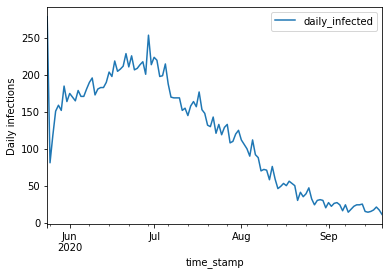

In [55]:
summary.groupby(['time_stamp']).sum().plot(y=['daily_infected'])
plt.ylabel('Daily infections')
plt.show()

### Hospital and intensive care

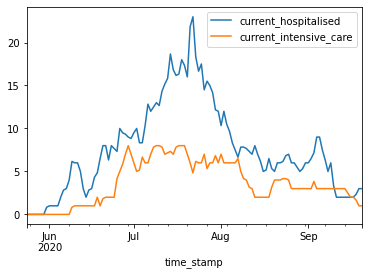

In [56]:
summary.groupby(['time_stamp']).sum().plot(y=['current_hospitalised', 'current_intensive_care'])
plt.show()

### Cumulative infections by age

In [57]:
infections_df = read.get_table_with_extras('infections',
                                           'infected_ids')

2022-04-18 16:10:32,455 - june.records.records_reader - INFO - Loading infections table
2022-04-18 16:10:32,481 - june.records.records_reader - INFO - Loading population table
2022-04-18 16:10:32,529 - june.records.records_reader - INFO - Merging infection and population tables
2022-04-18 16:10:32,541 - june.records.records_reader - INFO - Loading geography table
2022-04-18 16:10:32,563 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [58]:
deaths_df = read.get_table_with_extras('deaths', 
                                       'dead_person_ids')

2022-04-18 16:10:32,582 - june.records.records_reader - INFO - Loading deaths table
2022-04-18 16:10:32,589 - june.records.records_reader - INFO - Loading population table
2022-04-18 16:10:32,636 - june.records.records_reader - INFO - Merging infection and population tables
2022-04-18 16:10:32,641 - june.records.records_reader - INFO - Loading geography table
2022-04-18 16:10:32,661 - june.records.records_reader - INFO - Mergeing infection and geography tables


In [59]:
age_bins = (0,20,60,100)

In [60]:
infected_by_age = infections_df.groupby([pd.cut(infections_df['age'],
            bins=age_bins), 'timestamp']).size()

In [61]:
people_df = read.table_to_df('population')

In [62]:
n_by_age = people_df.groupby(pd.cut(people_df['age'],
            bins=age_bins)).size()

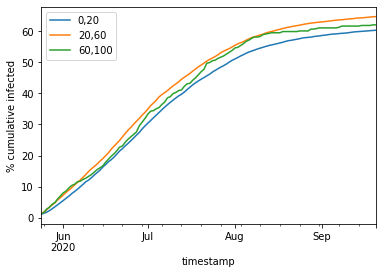

In [63]:
(100*infected_by_age/n_by_age).xs(10).cumsum().plot(label='0,20')
(100*infected_by_age/n_by_age).xs(30).cumsum().plot(label='20,60')
(100*infected_by_age/n_by_age).xs(70).cumsum().plot(label='60,100')
plt.ylabel("% cumulative infected")
plt.legend()

### Where people get infected

In [64]:
locations_df = infections_df.groupby(['location_specs', 
                                'timestamp']).size()

<AxesSubplot:xlabel='timestamp'>

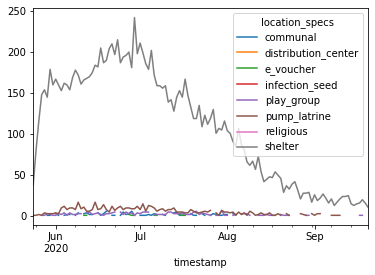

In [65]:
locations_df.unstack(level=0).plot()

Text(0.5, 0, 'location')

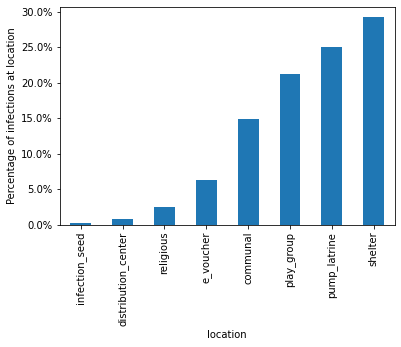

In [66]:
import matplotlib.ticker as mtick
location_counts_df = locations_df.groupby('location_specs').size()
location_counts_df = 100*location_counts_df / location_counts_df.sum()
ax = location_counts_df.sort_values().plot.bar()
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel('Percentage of infections at location')
plt.xlabel('location')